In [1]:
#FIUBA - 75.06 - 1C2020
#TP1 - Grupo 33

#Importacion de librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re 

#NLTK
#https://www.nltk.org
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from langdetect import detect

import networkx as nx

#Wordcloud
from wordcloud import WordCloud
from PIL import Image

#Configuracion general de matplotlib
%matplotlib inline
plt.style.use('default')

#Tamaños de textos
figure_sub_title_fs = 15
figure_labels_fs = 12
figure_axis_fs = 10
figure_legend_fs = 10

#Tamaño de la visualización, hoja A4
fig = plt.figure()
fig.set_size_inches(20,30)
wave_mask = np.array(Image.open("twitter-logo.jpg"))

#Formato de numeros reales
pd.options.display.float_format = '{:20,.2f}'.format

#Configuracion de warnings
warnings.filterwarnings('ignore')

#Limpia puntuacion, quita también usuarios y hashtags (@ y #)
def clean_tweet(words):
    result = []
    for word in words:
        stripped_word = word.strip()
        if ((stripped_word.isalnum() == True) and (not(stripped_word.isdigit()))):      
            result.append(stripped_word)
    
    return result

def filtrarPalabras(miArray):
    variable = ''
    for key in miArray:
         if '#' in str(key):
            variable = variable + ' ' + str(key)
    return variable

[nltk_data] Downloading package punkt to /Users/juan0511/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/juan0511/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juan0511/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<Figure size 2000x3000 with 0 Axes>

In [2]:
#Importacion del archivo CSV de fuente
#https://www.kaggle.com/c/nlp-getting-started
tweets = pd.read_csv('data/train.csv')
datos = pd.read_csv('data/train.csv')
nlp = pd.read_csv('data/train.csv')

#Vemos la estructura del dataframe, trayendo los primeros 5 registros
tweets.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [3]:
#Vemos la cantidad de registros
print("Shape: " + str(tweets.shape))

Shape: (7613, 5)


In [4]:
#Constatamos que en text y target no existen nulos
tweets.count()

id          7613
keyword     7552
location    5080
text        7613
target      7613
dtype: int64

In [5]:
#Relleno de nulos
tweets['keyword'] = tweets['keyword'].fillna('None')
tweets['location'] = tweets['location'].fillna('Unknown')

In [6]:
#Calculamos la longitud de los tweets en el set de datos, y la guardamos en una nueva columna
tweets['length'] = tweets['text'].str.len()

In [7]:
#Nos quedamos con los tweets que tienen target 0 y target 1 en 2 series, respectivamente
tweets_lengths_0 = tweets[tweets['target'] == 0]
tweets_lengths_0_s = tweets_lengths_0['length']
tweets_lengths_1 = tweets[tweets['target'] == 1]
tweets_lengths_1_s = tweets_lengths_1['length']

In [8]:
datos['text'] = datos['text'].str.lower()
datos['length'] = datos['text'].str.len()
datos['totalwords'] = datos['text'].str.split().str.len()
datos['words'] = datos.text.str.strip().str.split()

In [9]:
selected_words_singular=['fire','flood','inundate','earthquake','quake','deluge','euption','twister','tornado','hurricane', 'landslide','typhoon','wildfire','forest fire','drought','avalanche','urgent','important','danger','warrning','evacuation']
selected_words_plural=['fires','floods', 'earthquakes','quakes','deluges','rashes','tornadoes','hurricanes', 'landslides','typhoons','wildfires','forest fires','droughts','avalanches']
selected_words_other=['heat wave','died','flooding','flooded','damage','urgent','important','danger','warrning','help','evacuation']
col_one_list = datos['keyword'].tolist()
selected_words = selected_words_singular + selected_words_plural + selected_words_other + col_one_list
s = set(selected_words)

In [10]:
datos = datos.assign(hashtags=[filtrarPalabras(el) for el in datos.words])
datos = datos.assign(matches=[len(set(el) & s) for el in datos.words])
#datos.head()

In [11]:
SinMatchesConTarget = datos[(datos['target'] == 1) & (datos['matches'] == 0)]
pd.set_option('display.max_colwidth', -1)
#SinMatchesConTarget.head()

In [12]:
agrupado = datos.groupby(['target', 'matches', 'totalwords'])["id"].count().reset_index(name="cantidad")
agrupado = agrupado[['target','matches','totalwords','cantidad']]
#agrupado.head()

In [13]:
datos['language'] = detect(str(datos['text']))
datos['hashtagsCantidad'] = datos['hashtags'].str.count('#')
#datos.head()

## PREGUNTAS

### 3 - Análisis general sobre los tweets y su tamaño

#### 3.1 - ¿Cuál es la distribución de los tweets respecto a su target?

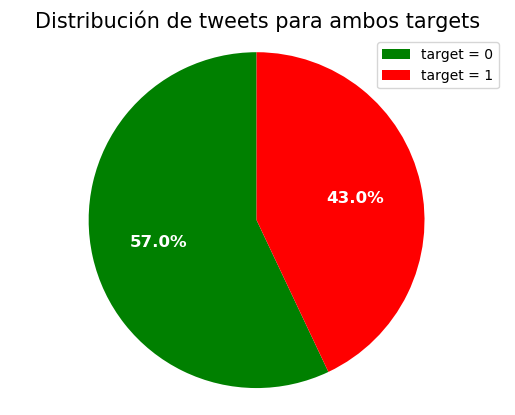

In [14]:
#Graficamos la distribucion de la longitud de los tweets, discriminada por target
fig = plt.figure()
ax1 = fig.add_subplot()
labels = "target = 0", "target = 1"
colors = ["green", "red"]
sizes = [tweets_lengths_0_s.count(), tweets_lengths_1_s.count()]
ax1.pie(sizes, colors=colors, autopct='%1.1f%%', shadow=False, startangle=90, textprops=dict(color="w",fontweight='bold', fontsize=figure_labels_fs))
ax1.axis('equal')
ax1.legend(labels,fontsize=figure_legend_fs)
ax1.set_title("Distribución de tweets para ambos targets", fontsize=figure_sub_title_fs)

plt.show()

#### 3.2 - ¿Cuáles son los idiomas predominantes en los tweets?

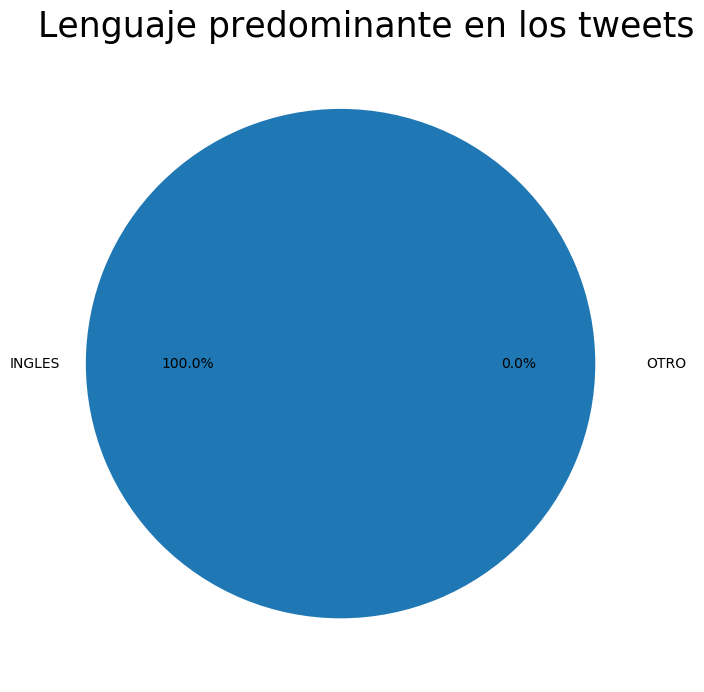

In [15]:
#Obtenemos las cantidades de propiedades con gimnasio
engSI = (datos[datos['language'] == 'en']).language.count()
engNO = (datos[datos['language'] != 'en']).language.count()
sizes = [engSI, engNO]
nombres = ['INGLES','OTRO']
# Tamaño para hojas A4.
plt.figure(figsize=(11.7, 8.27))
plt.title('Lenguaje predominante en los tweets', fontsize=25)
plt.pie(sizes, labels=nombres, autopct='%1.1f%%', shadow=False, explode=(0.1, 0))
plt.show()

#### 3.3 - ¿Existe correlación entre la longitud de los tweets y su target?

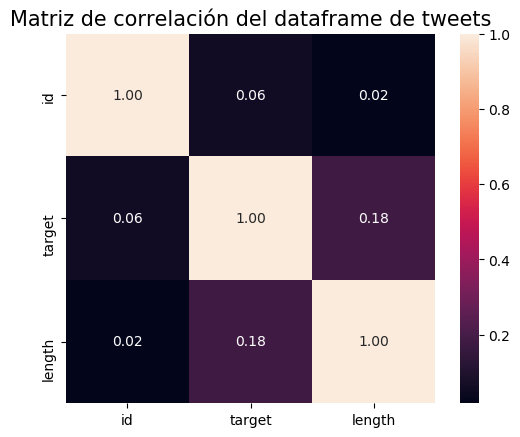

In [16]:
# Matriz de correlaciones como heatmap, variables numericas
plt.figure()
ax1 = sns.heatmap(tweets.corr(method='pearson', min_periods=1), square=True, annot=True, fmt='.2f')
ax1.set_title("Matriz de correlación del dataframe de tweets", fontsize=figure_sub_title_fs);

plt.show()

#### 3.4 - ¿Cuáles son las longitudes mínimas, medias y máximas, para cada target?

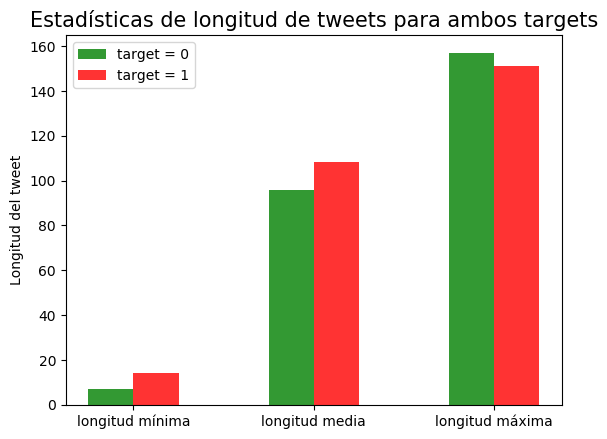

In [17]:
#Graficamos las estadisticas basicas de la longitud de los tweets
fig = plt.figure()
ax4 = fig.add_subplot()
barWidth = 0.25
bars1 = [tweets_lengths_0_s.min(), tweets_lengths_0_s.mean(), tweets_lengths_0_s.max()]
bars2 = [tweets_lengths_1_s.min(), tweets_lengths_1_s.mean(), tweets_lengths_1_s.max()]
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
plt.xticks([r + barWidth/2 for r in range(len(bars1))], ['longitud mínima', 'longitud media', 'longitud máxima'], fontsize=figure_axis_fs)
ax4.bar(r1, bars1, color='green', width=barWidth, label='target = 0', alpha=0.8)
ax4.bar(r2, bars2, color='red', width=barWidth, label='target = 1', alpha=0.8)
ax4.set_title("Estadísticas de longitud de tweets para ambos targets", fontsize=figure_sub_title_fs)
ax4.legend(["target = 0","target = 1"],fontsize=figure_legend_fs)
ax4.set_ylabel("Longitud del tweet", fontsize=figure_axis_fs)

plt.show()

#### 3.5 - ¿Cómo se distribuye la longitud de los tweets según su target?

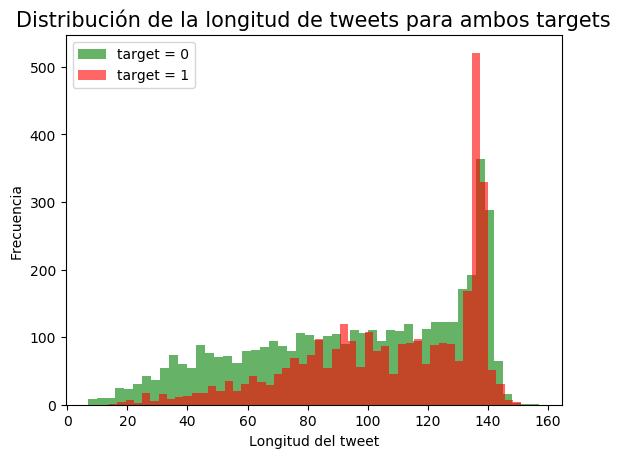

In [18]:
#Graficamos la distribucion de la longitud de los tweets, discriminada por target
#Histogramas superpuestos
fig = plt.figure()
ax2 = fig.add_subplot()
ax2 = tweets_lengths_0_s.plot.hist(bins=50, color='green',alpha=0.6)
ax2 = tweets_lengths_1_s.plot.hist(bins=50, color='red',alpha=0.6)
ax2.set_title("Distribución de la longitud de tweets para ambos targets", fontsize=figure_sub_title_fs)
ax2.legend(["target = 0","target = 1"],fontsize=figure_legend_fs)
ax2.set_xlabel("Longitud del tweet",fontsize=figure_axis_fs)
ax2.set_ylabel("Frecuencia", fontsize=figure_axis_fs)

plt.show()

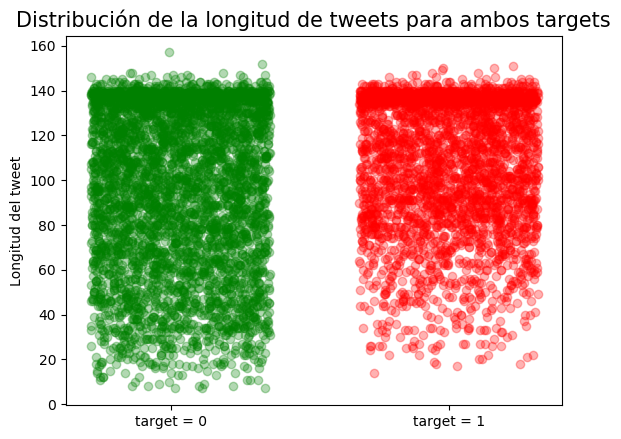

In [19]:
#Graficamos la distribucion de la longitud de los tweets, discriminada por target
#Scatterplot con jitter
fig = plt.figure()
ax3 = fig.add_subplot()
plt.xticks([0.18,0.80],['target = 0','target = 1'], fontsize=figure_axis_fs)
ax3.scatter(tweets_lengths_0['target'].apply(lambda n: n+(((np.random.random_sample()/2.5)))), tweets_lengths_0['length'], color='green', alpha=0.3)
ax3.scatter(tweets_lengths_1['target'].apply(lambda n: n-(((np.random.random_sample()/2.5)))), tweets_lengths_1['length'], color='red', alpha=0.3)
ax3.set_title("Distribución de la longitud de tweets para ambos targets", fontsize=figure_sub_title_fs)
ax3.set_ylabel("Longitud del tweet", fontsize=figure_axis_fs)

plt.show()

#### 3.6 - ¿Qué cantidad de tweets incluye información sobre location?

In [20]:
#Vemos cuantas locations hay
tweets['location'].value_counts()

Unknown               2535
USA                   104 
New York              71  
United States         50  
London                45  
                      ..  
Dalkeith, Scotland    1   
Somewhere             1   
Top secret bunker     1   
Unknown               1   
Bacon                 1   
Name: location, Length: 3341, dtype: int64

In [21]:
print("Total de tweets                : " + str(tweets['target'].count()) + "\n")

print("Cantidad de tweets con location: " + str((tweets['location'] == 'Unknown').value_counts().iloc[0]))
print("Cantidad de tweets sin location: " + str((tweets['location'] == 'Unknown').value_counts().iloc[1]))
print("Cantidad de locations unicas   : " + str(tweets['location'].value_counts().size))

Total de tweets                : 7613

Cantidad de tweets con location: 5078
Cantidad de tweets sin location: 2535
Cantidad de locations unicas   : 3341


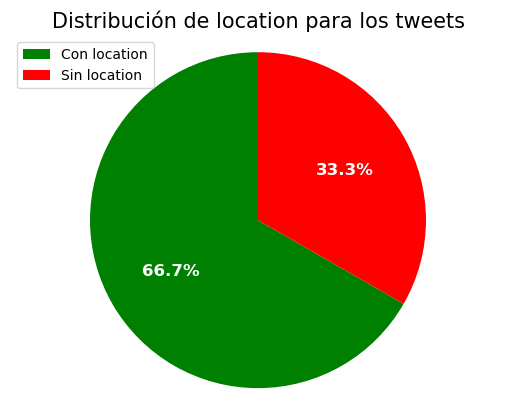

In [22]:
#Distribucion de tweets con location y sin location
fig = plt.figure()
ax1 = fig.add_subplot()
labels = "Con location", "Sin location"
sizes = [(tweets['location'] == 'Unknown').value_counts().iloc[0], (tweets['location'] == 'Unknown').value_counts().iloc[1]]
ax1.pie(sizes, colors=colors, autopct='%1.1f%%', shadow=False, startangle=90, textprops=dict(color="w",fontweight='bold', fontsize=figure_labels_fs))
ax1.axis('equal')
ax1.legend(labels,fontsize=figure_legend_fs)
ax1.set_title("Distribución de location para los tweets", fontsize=figure_sub_title_fs)

plt.show()

#### 3.7 - ¿Cuántas location únicas existen?

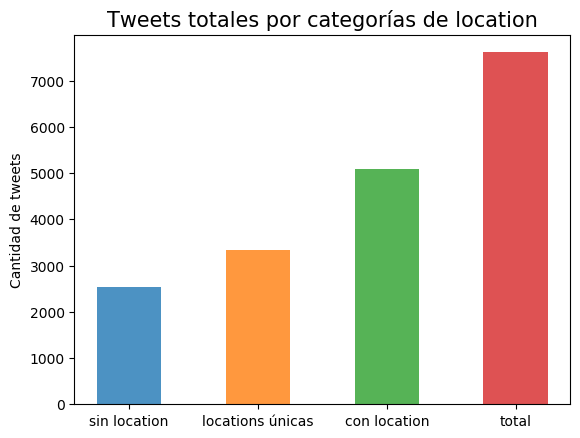

In [23]:
#Graficamos las estadisticas basicas de la longitud de los tweets
fig = plt.figure()
ax4 = fig.add_subplot()
barWidth = 0.25
bars1 = [(tweets['location'] == 'Unknown').value_counts().iloc[1]]
bars2 = [tweets['location'].value_counts().size]
bars3 = [(tweets['location'] == 'Unknown').value_counts().iloc[0]]
bars4 = [tweets['target'].count()]

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

plt.xticks([0,0.5,1,1.5], ['sin location', 'locations únicas', 'con location', 'total'], fontsize=figure_axis_fs)
ax4.bar(0, bars1, width=barWidth, label='target = 0', alpha=0.8)
ax4.bar(0.5, bars2, width=barWidth, label='target = 1', alpha=0.8)
ax4.bar(1, bars3, width=barWidth, label='target = 1', alpha=0.8)
ax4.bar(1.5, bars4, width=barWidth, label='target = 1', alpha=0.8)

ax4.set_title("Tweets totales por categorías de location", fontsize=figure_sub_title_fs)
ax4.set_ylabel("Cantidad de tweets", fontsize=figure_axis_fs)

plt.show()

#### 3.8 - ¿Cuáles son las 15 locations más populares?

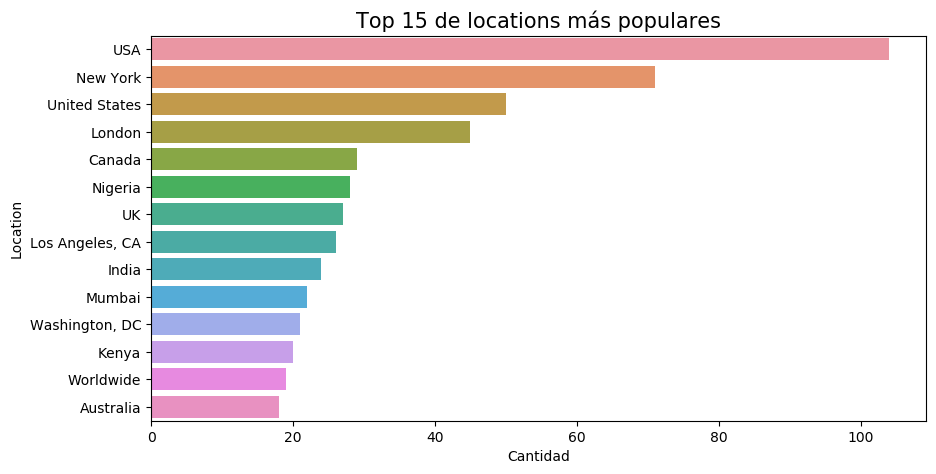

In [24]:
#25 locations mas populares - sacamos el unknown, que es el mas popular
tweets_top_locations_df = tweets[tweets['location'] != 'Unknown']
tweets_top_locations = tweets['location'].value_counts().head(15)
tweets_top_locations = tweets_top_locations.drop(tweets_top_locations.index[0])

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot()

ax1 = sns.barplot(x=tweets_top_locations.values, y=tweets_top_locations.index)
ax1.set_xlabel("Cantidad",fontsize=figure_axis_fs)
ax1.set_ylabel("Location",fontsize=figure_axis_fs)
ax1.set_title("Top 15 de locations más populares", fontsize=figure_sub_title_fs)
plt.show()

#### 3.9 - ¿Cómo se distribuyen las 15 locations más populares según el target?

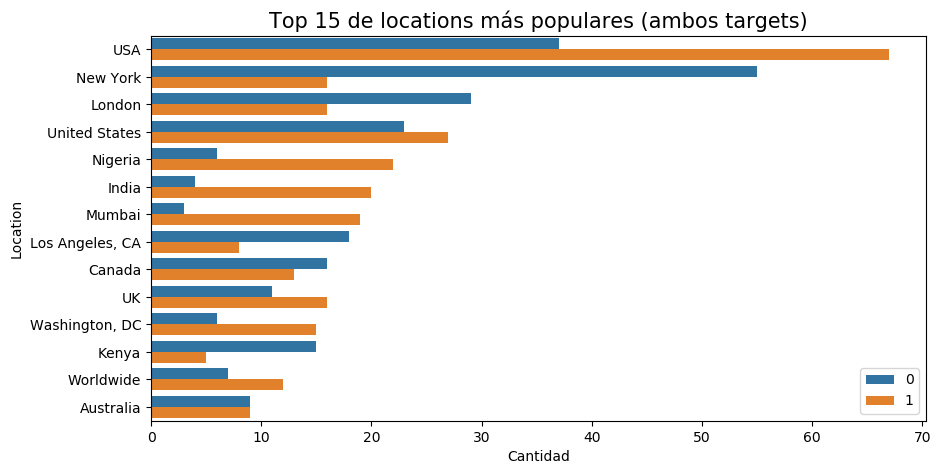

In [25]:
#Combinamos los mas populares con ambos targets, separados por target
tweets_top_locations_count_grouped = tweets_top_locations_df.groupby(['location','target']).size().reset_index()
tweets_top_locations_count_grouped = tweets_top_locations_count_grouped.rename(columns={0:'count'})

tweets_top_locations_count_grouped['populares'] = tweets_top_locations_count_grouped['location'].isin(tweets_top_locations.index)
tweets_top_locations_count_grouped_filtered = tweets_top_locations_count_grouped[tweets_top_locations_count_grouped['populares']==True]
tweets_top_locations_count_grouped_filtered_sorted = tweets_top_locations_count_grouped_filtered.sort_values(('count'),ascending=False)
tweets_top_locations_count_grouped_filtered_sorted

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot()
ax1 = sns.barplot(x='count', y='location', hue='target', data=tweets_top_locations_count_grouped_filtered_sorted)
ax1.set_xlabel("Cantidad",fontsize=figure_axis_fs)
ax1.set_ylabel("Location",fontsize=figure_axis_fs)
ax1.legend(fontsize=figure_legend_fs)
ax1.set_title("Top 15 de locations más populares (ambos targets)", fontsize=figure_sub_title_fs)
plt.show()

### 4 - Análisis general sobre las palabras que forman los tweets

#### 4.1 - ¿Cuáles son las palabras más populares en el set de datos?

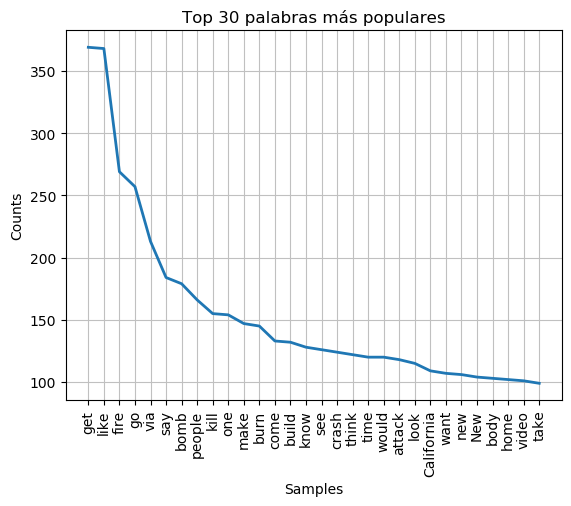

In [26]:
#Separamos las plabras de los tweets, usamos el tokenizador de twitter de nltk
tt = TweetTokenizer()
tweets_generales = tweets

tweets_generales['text tokenized'] = tweets_generales['text'].apply(tt.tokenize)
tweets_generales['text tokenized'] = tweets_generales['text tokenized'].apply(clean_tweet)

#Armamos una lista con todas las palabras
tweets_words = []
for row in tweets_generales['text tokenized']:
    for word in row:
        tweets_words.append(word)

#Sabiendo que todos los tweets son en idioma ingles, quitamos las stopwords, y volvemos a graficar
stop_words=set(stopwords.words("english"))
tweets_words_filtered = []
for word in tweets_words:
    if word.lower() not in stop_words:
        tweets_words_filtered.append(word)

#Obtenemos los lemas y graficamos
lem = WordNetLemmatizer()
tweets_words_filtered_lemmatized=[]
for word in tweets_words_filtered:
    tweets_words_filtered_lemmatized.append(lem.lemmatize(word,"v"))

fdist = FreqDist(tweets_words_filtered_lemmatized)
fdist.plot(30, cumulative=False, title="Top 30 palabras más populares")

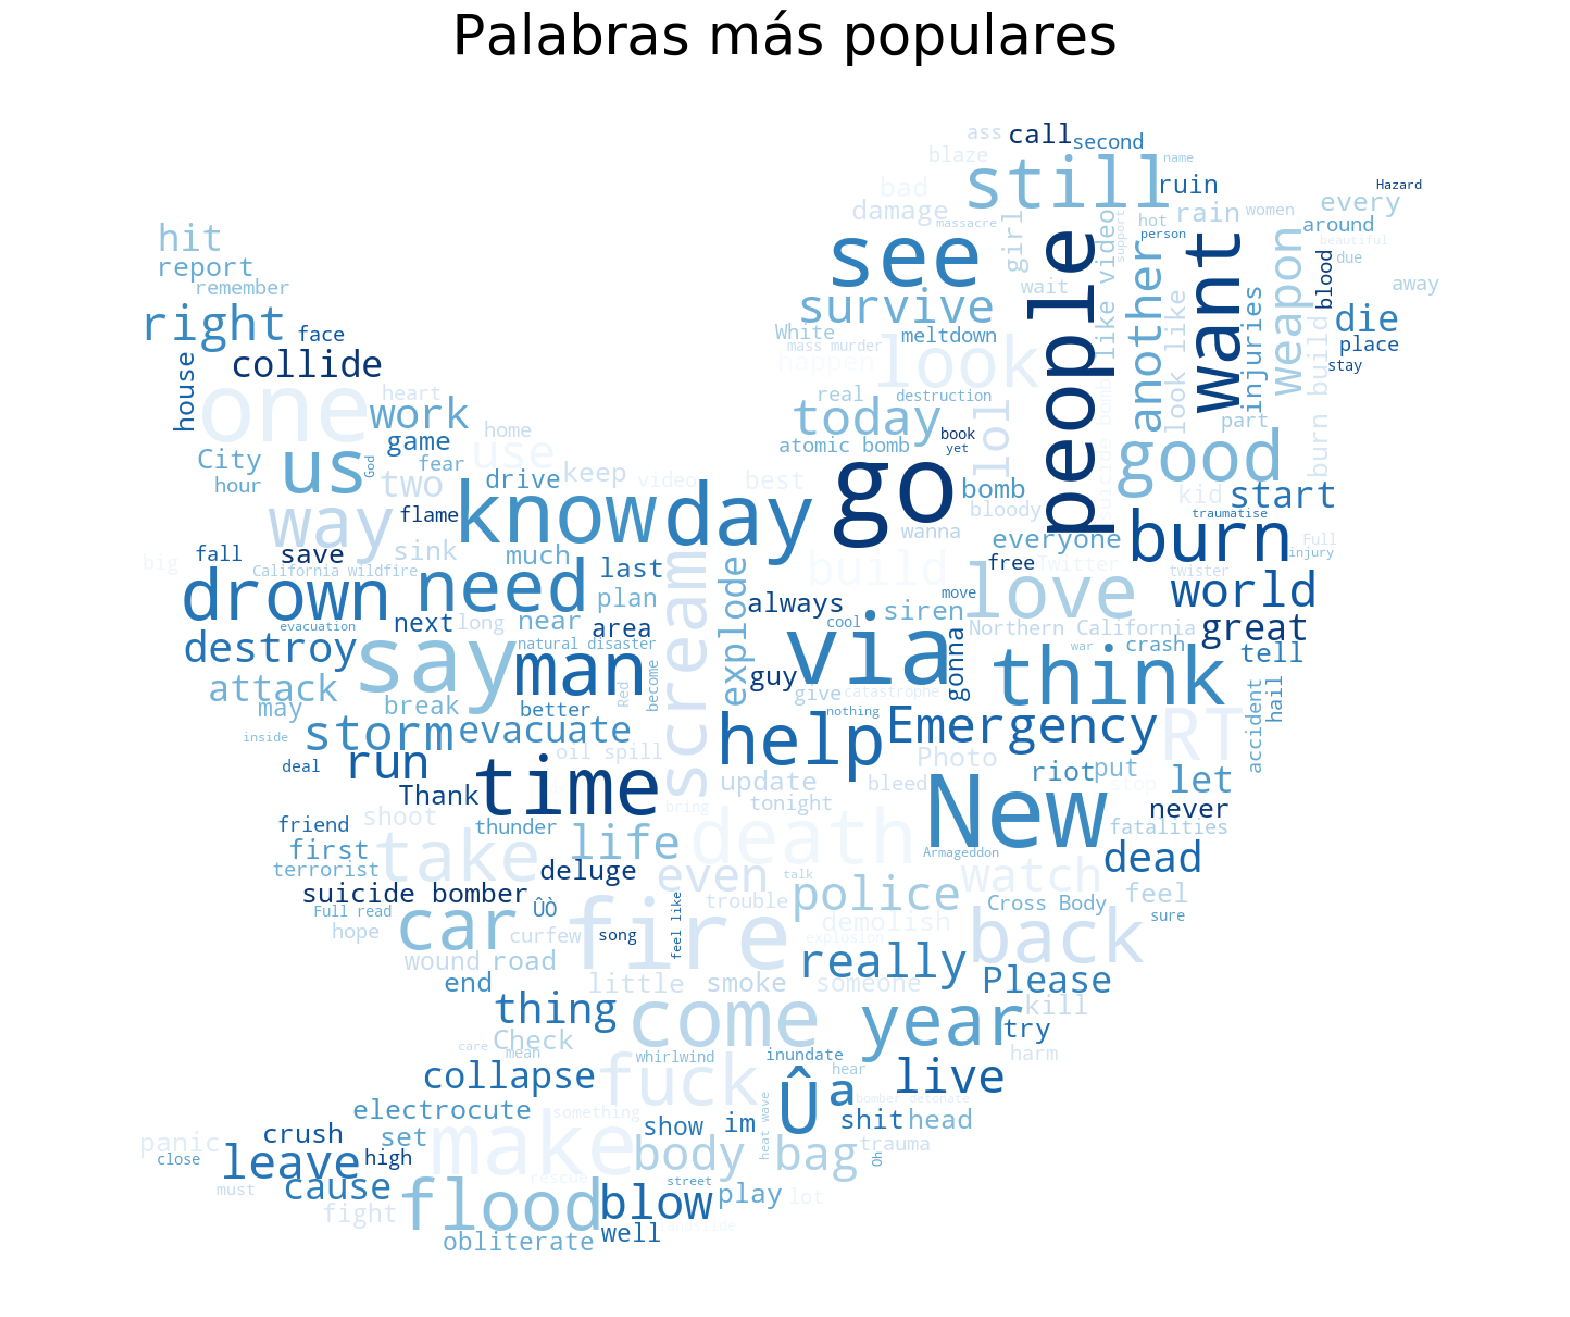

In [27]:
plt.figure(figsize=(20,20))
wordcloud = WordCloud(mask=wave_mask, colormap="Blues",max_font_size=100, max_words=250,background_color="white").\
    generate(str(tweets_words_filtered_lemmatized).replace("'", "").replace(" ",""))
plt.title('Palabras más populares',fontsize=40)
plt.margins(x=0, y=0)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### 4.2 - ¿Cuáles son las palabras más populares en el set de datos, para target = 0?

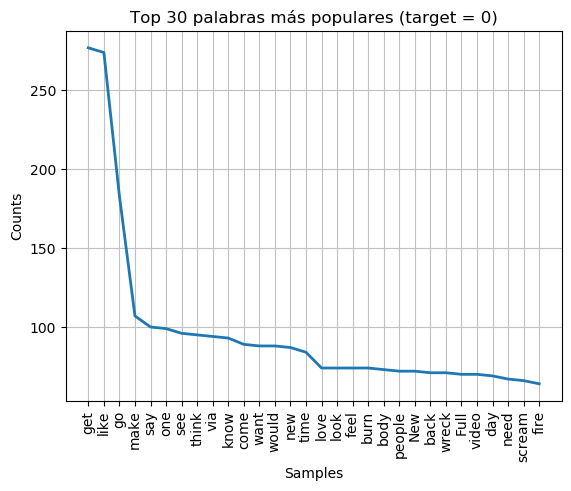

In [28]:
#Separamos las plabras de los tweets, usamos el tokenizador de twitter de nltk
tt = TweetTokenizer()
tweets_target_0 = tweets[tweets['target'] == 0]

tweets_target_0['text tokenized'] = tweets_target_0['text'].apply(tt.tokenize)
tweets_target_0['text tokenized'] = tweets_target_0['text tokenized'].apply(clean_tweet)

#Armamos una lista con todas las palabras
tweets_words = []
for row in tweets_target_0['text tokenized']:
    for word in row:
        tweets_words.append(word)

#Sabiendo que todos los tweets son en idioma ingles, quitamos las stopwords, y volvemos a graficar
stop_words=set(stopwords.words("english"))
tweets_words_filtered = []
for word in tweets_words:
    if word.lower() not in stop_words:
        tweets_words_filtered.append(word)

#Obtenemos los lemas y graficamos
lem = WordNetLemmatizer()
tweets_words_filtered_lemmatized=[]
for word in tweets_words_filtered:
    tweets_words_filtered_lemmatized.append(lem.lemmatize(word,"v"))

fdist = FreqDist(tweets_words_filtered_lemmatized)
fdist.plot(30, cumulative=False, title="Top 30 palabras más populares (target = 0)")

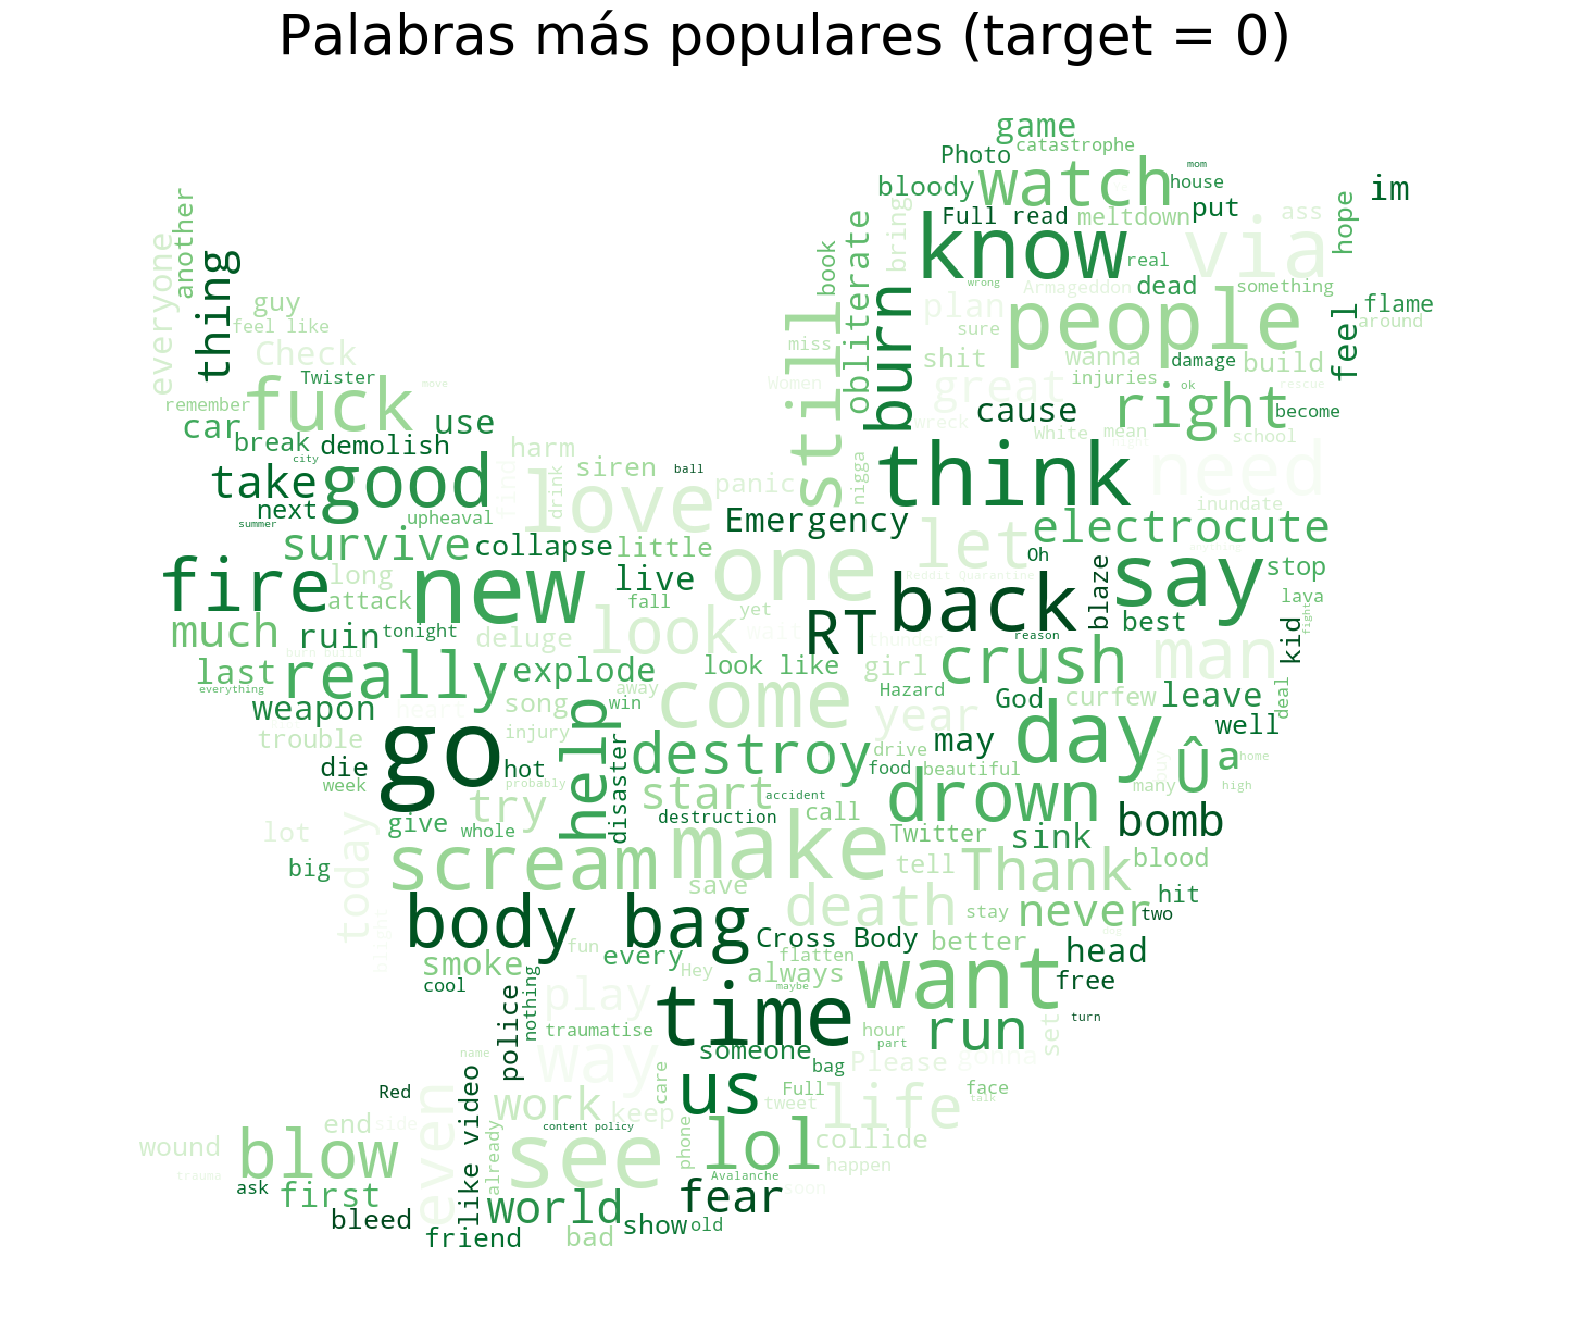

In [29]:
plt.figure(figsize=(20,20))
wordcloud = WordCloud(mask=wave_mask, colormap="Greens",max_font_size=100, max_words=250,background_color="white").\
    generate(str(tweets_words_filtered_lemmatized).replace("'", "").replace(" ",""))
plt.title('Palabras más populares (target = 0)',fontsize=40)
plt.margins(x=0, y=0)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### 4.3 - ¿Cuáles son las palabras más populares en el set de datos, para target = 1?

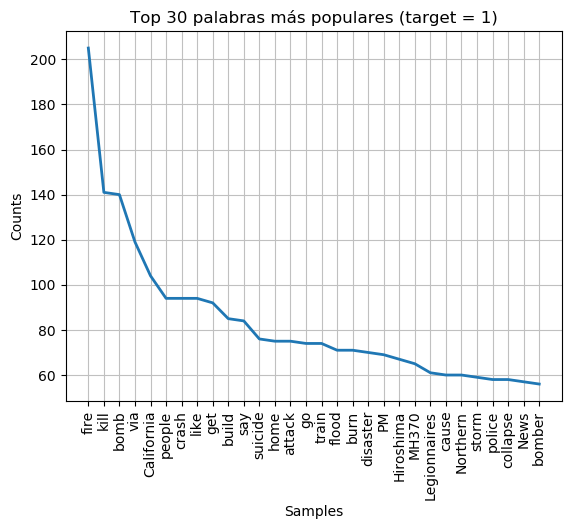

In [30]:
#Separamos las plabras de los tweets, usamos el tokenizador de twitter de nltk
tt = TweetTokenizer()
tweets_target_1 = tweets[tweets['target'] == 1]

tweets_target_1['text tokenized'] = tweets_target_1['text'].apply(tt.tokenize)
tweets_target_1['text tokenized'] = tweets_target_1['text tokenized'].apply(clean_tweet)

#Armamos una lista con todas las palabras
tweets_words = []
for row in tweets_target_1['text tokenized']:
    for word in row:
        tweets_words.append(word)

#Sabiendo que todos los tweets son en idioma ingles, quitamos las stopwords, y volvemos a graficar
stop_words=set(stopwords.words("english"))
tweets_words_filtered = []
for word in tweets_words:
    if word.lower() not in stop_words:
        tweets_words_filtered.append(word)

#Obtenemos los lemas y graficamos
lem = WordNetLemmatizer()
tweets_words_filtered_lemmatized=[]
for word in tweets_words_filtered:
    tweets_words_filtered_lemmatized.append(lem.lemmatize(word,"v"))
    
fdist = FreqDist(tweets_words_filtered_lemmatized)
fdist.plot(30,cumulative=False, title="Top 30 palabras más populares (target = 1)")

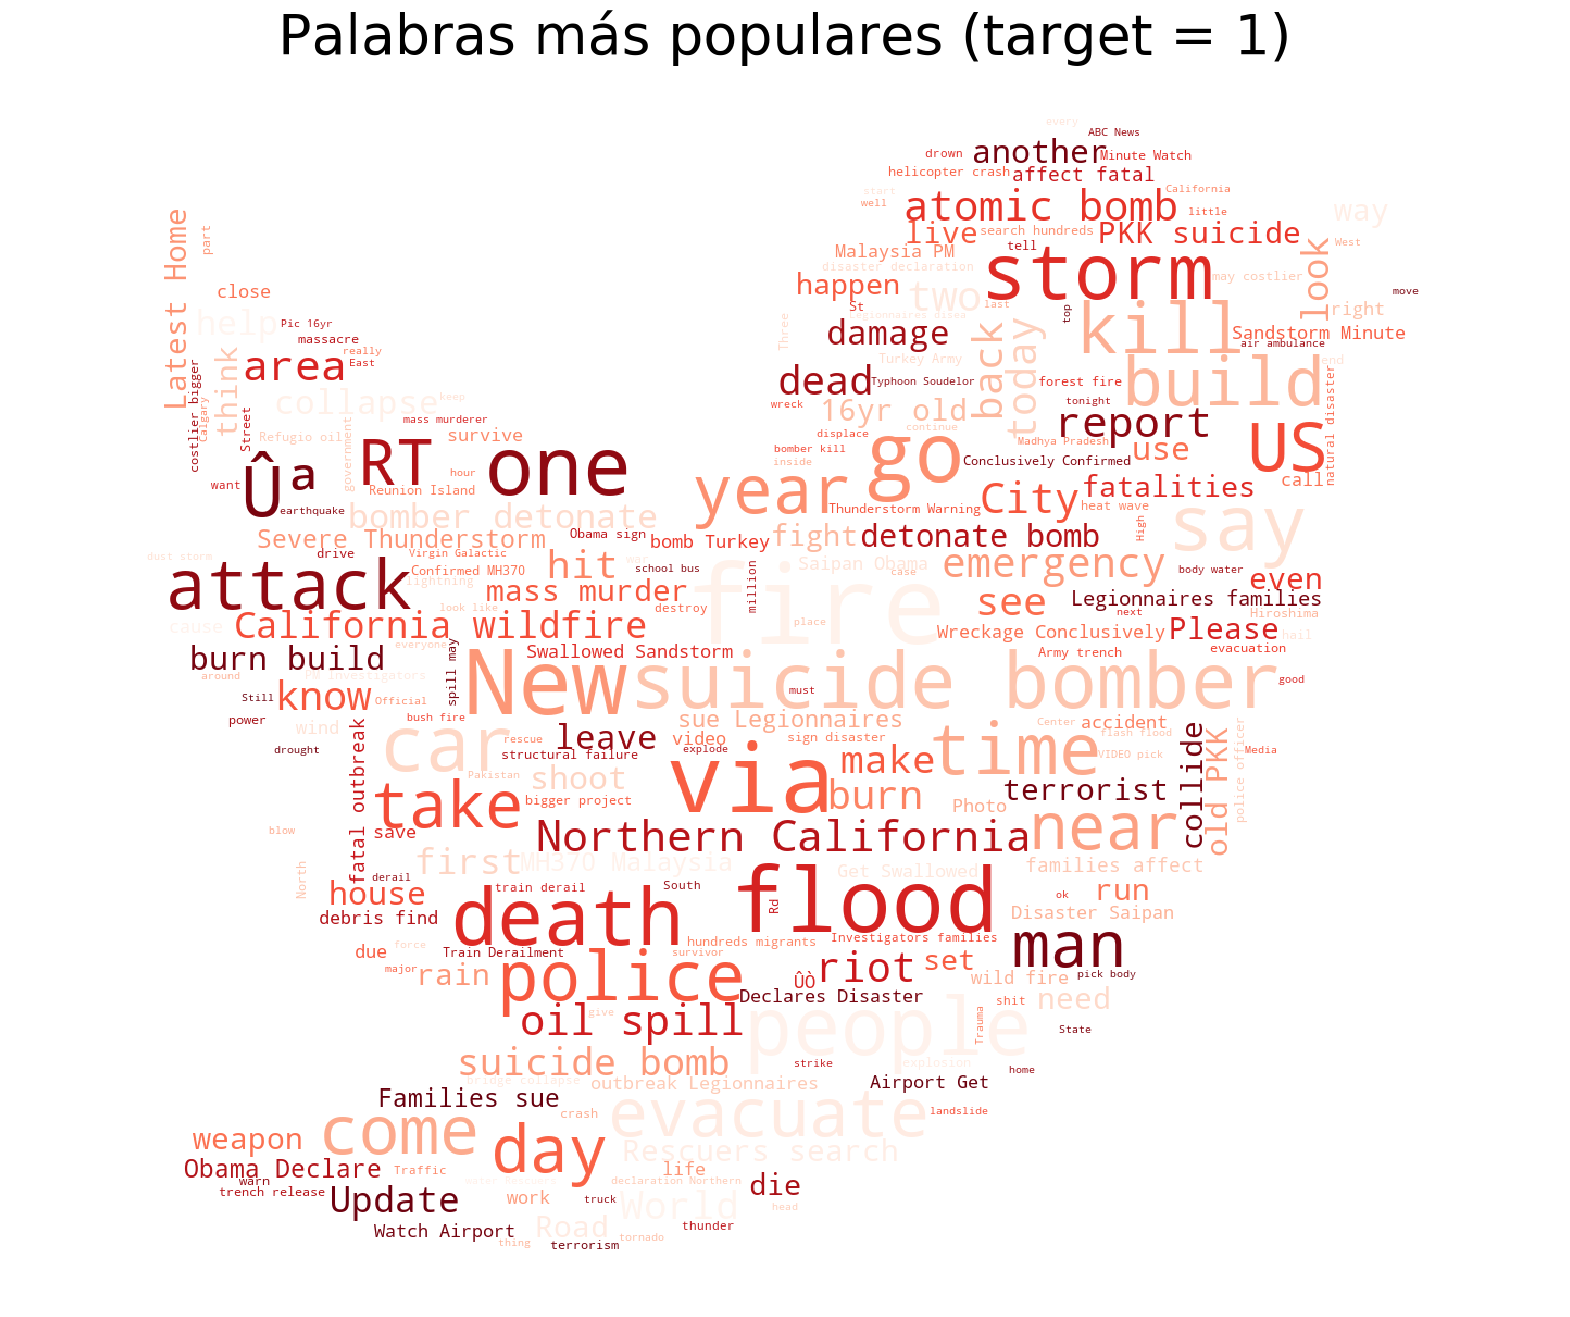

In [31]:
plt.figure(figsize=(20,20))
wordcloud = WordCloud(mask=wave_mask, colormap="Reds",max_font_size=100, max_words=250,background_color="white").\
    generate(str(tweets_words_filtered_lemmatized).replace("'", "").replace(" ",""))
plt.title('Palabras más populares (target = 1)',fontsize=40)
plt.margins(x=0, y=0)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### 4.4 - ¿Cómo se relaciona la longitud de los tweets con la cantidad de palabras?

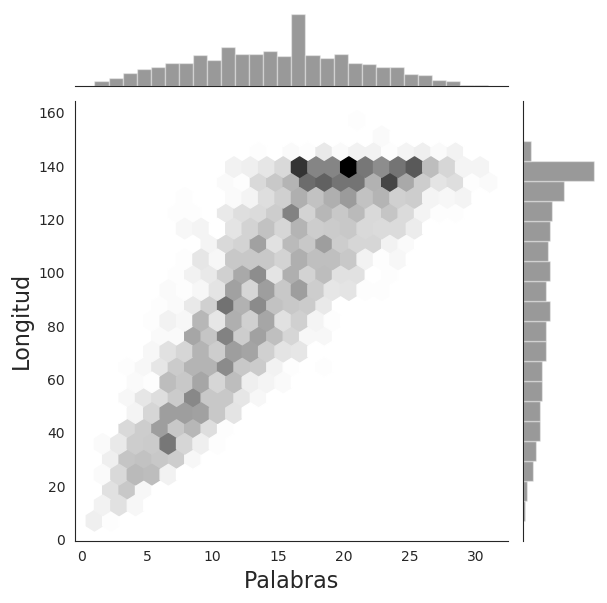

In [32]:
target1 = datos.loc[(datos['target'] == 1) & (datos['keyword'].notnull())]
target0 = datos.loc[(datos['target'] == 0) & (datos['keyword'].notnull())]
target1_WC = datos.loc[datos['target'] == 1]
target0_WC = datos.loc[datos['target'] == 0]

with sns.axes_style("white"):
    h = sns.jointplot(x=target0['totalwords'], y=target0['length'], kind="hex", color="k");
    h.set_axis_labels('Palabras', 'Longitud', fontsize=16)

#### 4.5 - ¿Cuál es la interpretación entre tamaño, cantidad de palabras y las palabras claves?

<Figure size 1170x827 with 0 Axes>

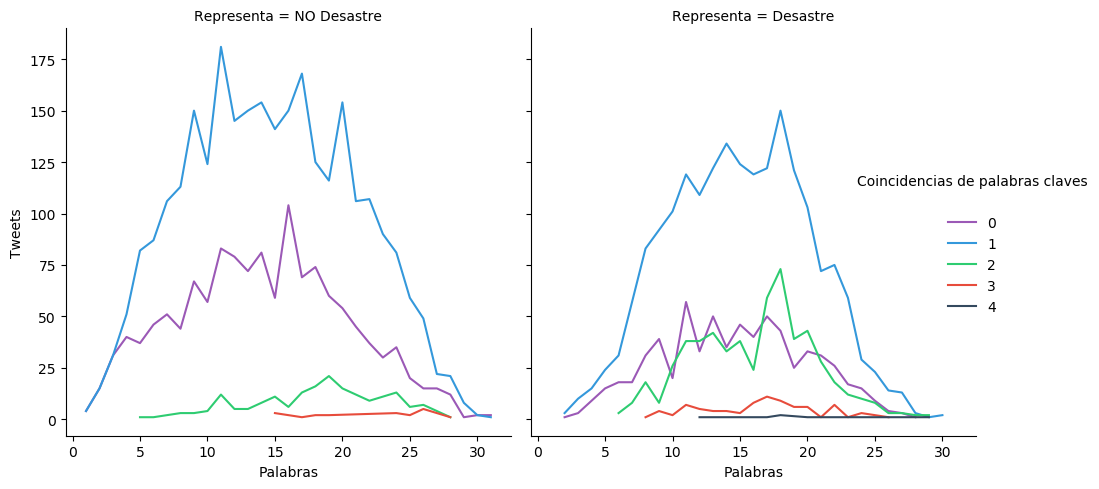

In [33]:
agrupado['Representa'] = "NO Desastre"
agrupado.loc[agrupado['target'] == 1, 'Representa'] = "Desastre"

plt.figure(figsize=(11.7, 8.27))
flatui = ["#9b59b6", "#3498db", "#2ecc71", "#e74c3c", "#34495e"]
g = sns.relplot(x="totalwords", y="cantidad", col="Representa", palette=flatui,  hue="matches", kind="line", data=agrupado)
g._legend.texts[0].set_text("")
g._legend.set_title("Coincidencias de palabras claves")
g.set(xlabel='Palabras', ylabel='Tweets')

#### 4.6 ¿Hay alguna relación entre los signos de exclamación (!)/pregunta (?) y el target?

Text(0, 0.5, 'Cantidad')

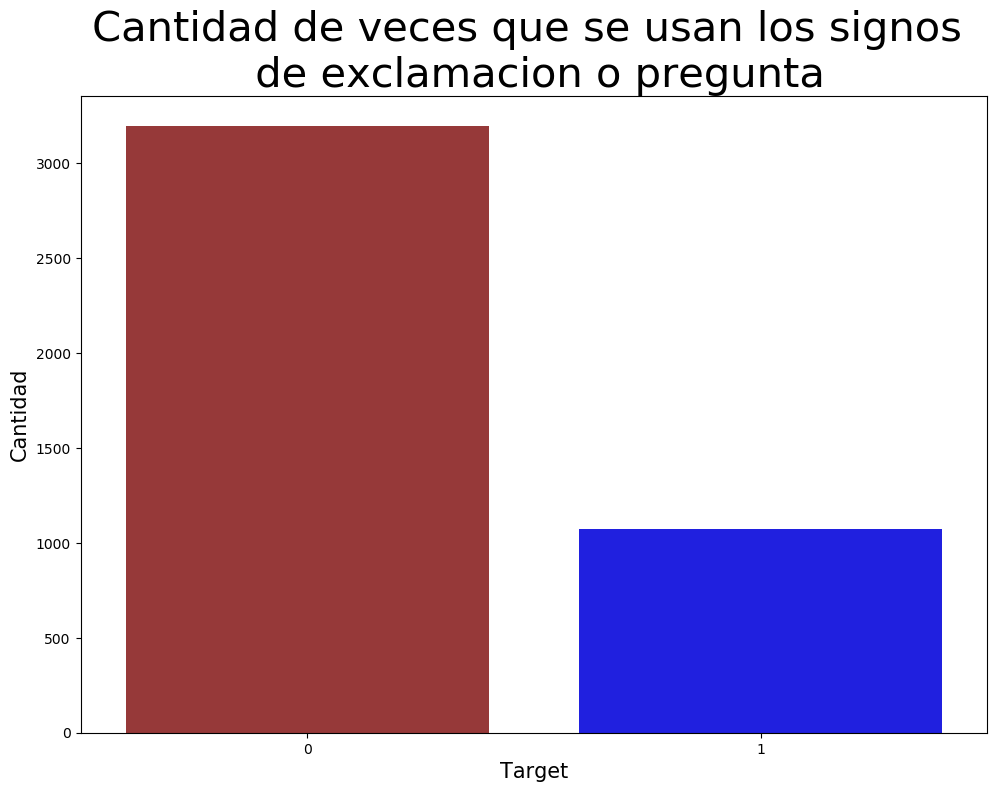

In [34]:
signs = nlp[['keyword', 'target', 'text']]
signs.dropna(inplace=True)

signs['ask'] = signs['text'].str.count('[!]') + signs['text'].str.count('[?]')
signs_agrupado = signs.groupby('target').sum().rename(columns={'ask':'cantidad'}).reset_index()

# Tamaño para hojas A4.
plt.figure(figsize=(11.7, 8.27))

ax = sns.barplot(x='target', y='cantidad', data=signs_agrupado, palette=["brown", "blue"])

ax.set_title("Cantidad de veces que se usan los signos \n de exclamacion o pregunta",fontsize=30)
ax.set_xlabel("Target",fontsize=15)
ax.set_ylabel("Cantidad",fontsize=15)

### 5 - Análisis general sobre las keywords asignadas a los tweets

#### 5.1 - ¿Cuántos tweet están asociados a una keyword?

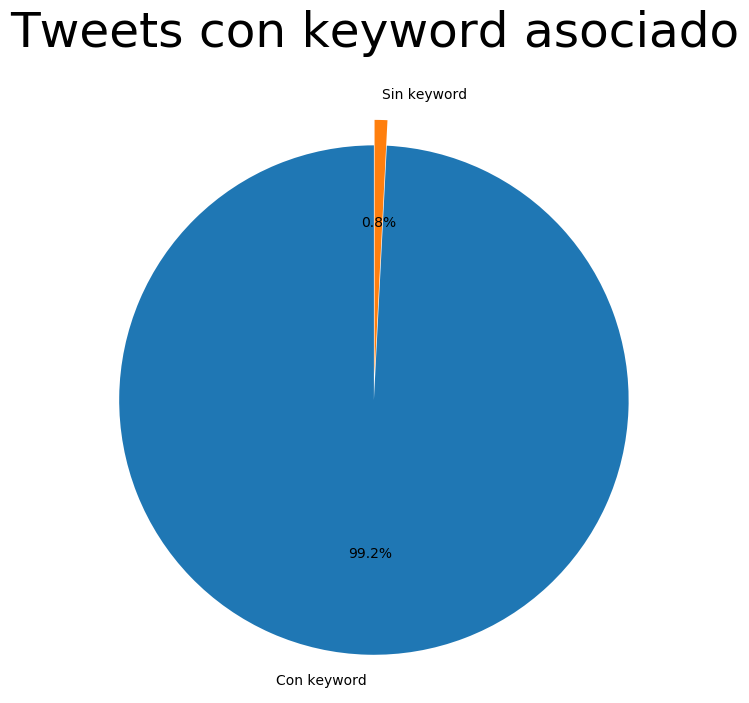

In [35]:
sin_keyword = nlp['keyword'].isnull().sum()
con_keyword = nlp['keyword'].count()-sin_keyword

sizes = [con_keyword, sin_keyword]
nombres = ["Con keyword", "Sin keyword"]

plt.figure(figsize=(11.7, 8.27))
plt.title('Tweets con keyword asociado', fontsize=35)
plt.pie(sizes, labels=nombres, autopct='%1.1f%%', startangle=90, explode=(0.1, 0))
plt.show()

#### 5.2 - ¿Cuáles son las keywords más utilizadas?

Text(0, 0.5, 'Keyword')

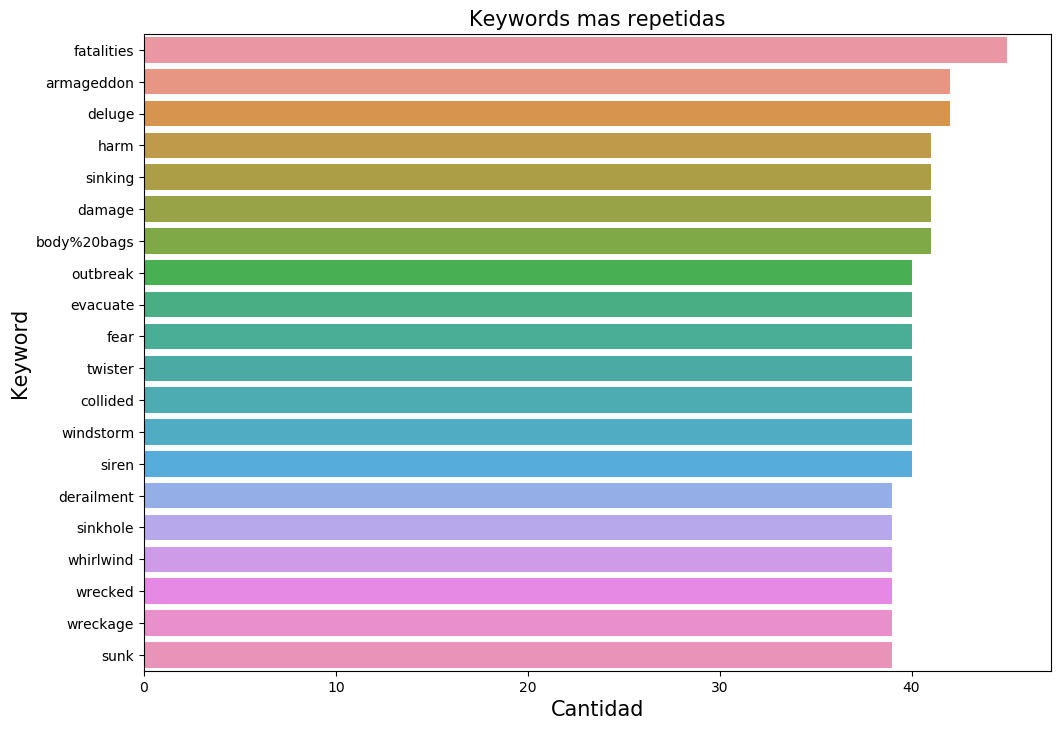

In [36]:
cant_keyword = nlp['keyword'].value_counts().iloc[:20]

#KEYWORDS MAS POPULARES PARA TODOS LOS TARGET
# Tamaño para hojas A4.
plt.figure(figsize=(11.7, 8.27))

ax = sns.barplot(x=cant_keyword.values, y=cant_keyword.index)

ax.set_title("Keywords mas repetidas",fontsize=15)
ax.set_xlabel("Cantidad",fontsize=15)
ax.set_ylabel("Keyword",fontsize=15)

#### 5.3 - ¿Cómo se distribuyen por target dichos keywords?

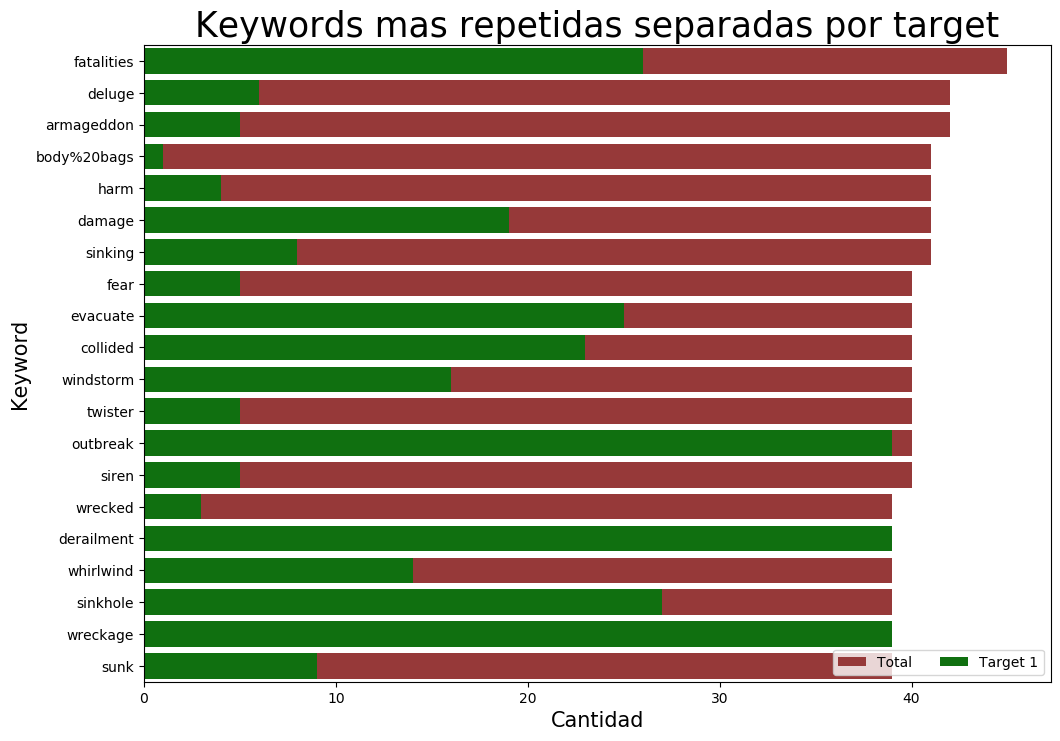

In [37]:
keywords_df = nlp.groupby(['keyword', 'target'])[['text']].count().reset_index()
keywords_df['populares'] = keywords_df['keyword'].isin(cant_keyword.index)
keywords_df = keywords_df[keywords_df['populares']==True].sort_values(by='text', ascending=False)
#keywords_df.head()

cant_keyword = nlp['keyword'].value_counts().iloc[:20]
#cant_keyword.head(3)

df_target1 = keywords_df[keywords_df['target']==1].reset_index().rename(columns={'text':'cant_target1'})
df_target0 = keywords_df[keywords_df['target']==0].reset_index().rename(columns={'text':'cant_target0'})
df_totales = df_target1.merge(df_target0, how='outer', on='keyword')[['keyword', 'cant_target1', 'cant_target0' ]]
df_totales.fillna(0, inplace=True)
df_totales['cant_totales'] = df_totales['cant_target1'] + df_totales['cant_target0']
df_totales.sort_values(by='cant_totales', ascending = False, inplace=True)
#df_totales.head(50)

#COMPARACION ENTRE TARGET 1 Y TARGET 0 DE LAS KEYWORDS MAS POPULARES PARA LOS 2
# Tamaño para hojas A4.
f, ax = plt.subplots(figsize=(11.7, 8.27))


sns.barplot(x='cant_totales', y='keyword', data=df_totales, label="Total", color="brown")            
sns.barplot(x='cant_target1', y="keyword", data=df_totales, label="Target 1", color="green")

ax.set_title("Keywords mas repetidas separadas por target",fontsize=25)
ax.set_xlabel("Cantidad",fontsize=15)
ax.set_ylabel("Keyword",fontsize=15)

ax.legend(ncol=2, loc="lower right", frameon=True)

#### 5.4 - ¿Cómo trabajan las keywords más representativas?

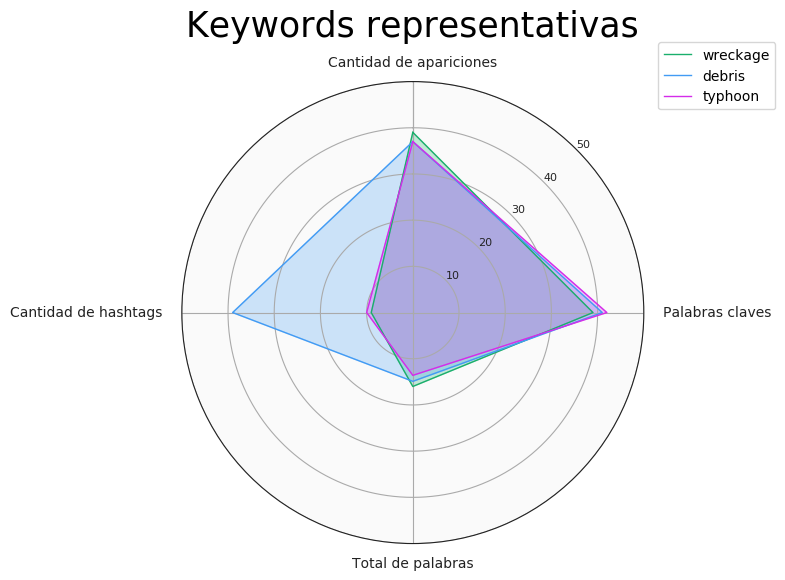

In [38]:
def obtenerValuesDelRow(df):
    my_list = []
    for index, rows in df.iterrows(): 
        my_list = [rows['Cantidad de apariciones'], rows['Palabras claves'], rows['Total de palabras'], rows['Cantidad de hashtags']] 
    return my_list

target1.head()
result = target1.groupby(['keyword']).agg({'id':'count','matches':'sum','totalwords':np.average,'length':np.average, 'hashtagsCantidad':'sum'}).reset_index()
result.rename(columns={'id':'Cantidad de apariciones', 'matches':'Palabras claves', 'totalwords': 'Total de palabras', 'length':'Longitud', 'hashtagsCantidad':'Cantidad de hashtags'}, inplace=True)
#result.head()

target1matches2 = target1.loc[target1['matches'] > 0]
keywordsMAX = target1matches2.groupby(['keyword'])["id"].count().reset_index(name="cantidad").nlargest(10, 'cantidad')
#keywordsMAX.head(10)

target0matches2 = target1.loc[target1['matches'] > 0]
keywordsMIN = target0matches2.groupby(['keyword'])["id"].count().reset_index(name="cantidad").nsmallest(100, 'cantidad')
#keywordsMIN.head(200)

resultTarget1MAX = result.nlargest(200, 'Cantidad de apariciones')
resultTarget1MIN = result.nsmallest(200, 'Cantidad de apariciones')

# Each attribute we'll plot in the radar chart.
labels = ['Cantidad de apariciones', 'Palabras claves', 'Total de palabras', 'Cantidad de hashtags']

# Number of variables we're plotting.
num_vars = len(labels)

# Split the circle into even parts and save the angles
# so we know where to put each axis.
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is a circle, so we need to "complete the loop"
# and append the start value to the end.
angles += angles[:1]

# ax = plt.subplot(polar=True)
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Helper function to plot each car on the radar chart.
def add_to_radar(car_model, color):
  outbreak = resultTarget1MAX.loc[resultTarget1MAX['keyword'] == car_model]  
  values = obtenerValuesDelRow(outbreak) #resultTarget1.loc[car_model].tolist()
  values += values[:1]
  ax.plot(angles, values, color=color, linewidth=1, label=car_model)
  ax.fill(angles, values, color=color, alpha=0.25)

# Add each car to the chart.
add_to_radar('wreckage', '#1aaf6c')
add_to_radar('debris', '#429bf4')
add_to_radar('typhoon', '#d42cea')

# Fix axis to go in the right order and start at 12 o'clock.
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Draw axis lines for each angle and label.
ax.set_thetagrids(np.degrees(angles), labels)

# Go through labels and adjust alignment based on where
# it is in the circle.
for label, angle in zip(ax.get_xticklabels(), angles):
  if angle in (0, np.pi):
    label.set_horizontalalignment('center')
  elif 0 < angle < np.pi:
    label.set_horizontalalignment('left')
  else:
    label.set_horizontalalignment('right')

# Ensure radar goes from 0 to 100.
ax.set_ylim(0, 50)
# You can also set gridlines manually like this:
# ax.set_rgrids([20, 40, 60, 80, 100])

# Set position of y-labels (0-100) to be in the middle
# of the first two axes.
ax.set_rlabel_position(180 / num_vars)
# Add some custom styling.
# Change the color of the tick labels.
ax.tick_params(colors='#222222')
# Make the y-axis (0-100) labels smaller.
ax.tick_params(axis='y', labelsize=8)
# Change the color of the circular gridlines.
ax.grid(color='#AAAAAA')
# Change the color of the outermost gridline (the spine).
ax.spines['polar'].set_color('#222222')
# Change the background color inside the circle itself.
ax.set_facecolor('#FAFAFA')
# Add title.
ax.set_title('Keywords representativas', y=1.08, fontsize=25)
# Add a legend as well.
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

#### 5.5 - ¿Cómo trabajan las keywords menos representativas?

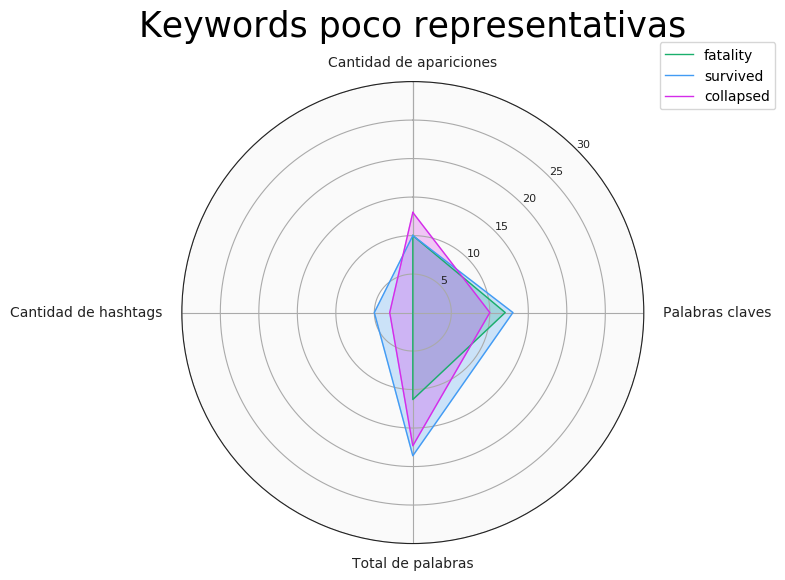

In [39]:
# Each attribute we'll plot in the radar chart.
labels = ['Cantidad de apariciones', 'Palabras claves', 'Total de palabras', 'Cantidad de hashtags']

# Number of variables we're plotting.
num_vars = len(labels)

# Split the circle into even parts and save the angles
# so we know where to put each axis.
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is a circle, so we need to "complete the loop"
# and append the start value to the end.
angles += angles[:1]

# ax = plt.subplot(polar=True)
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Helper function to plot each car on the radar chart.
def add_to_radar(car_model, color):
  outbreak = resultTarget1MIN.loc[resultTarget1MIN['keyword'] == car_model]  
  values = obtenerValuesDelRow(outbreak) #resultTarget1.loc[car_model].tolist()
  values += values[:1]
  ax.plot(angles, values, color=color, linewidth=1, label=car_model)
  ax.fill(angles, values, color=color, alpha=0.25)

# Add each car to the chart.
add_to_radar('fatality', '#1aaf6c')
add_to_radar('survived', '#429bf4')
add_to_radar('collapsed', '#d42cea')

# Fix axis to go in the right order and start at 12 o'clock.
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Draw axis lines for each angle and label.
ax.set_thetagrids(np.degrees(angles), labels)

# Go through labels and adjust alignment based on where
# it is in the circle.
for label, angle in zip(ax.get_xticklabels(), angles):
  if angle in (0, np.pi):
    label.set_horizontalalignment('center')
  elif 0 < angle < np.pi:
    label.set_horizontalalignment('left')
  else:
    label.set_horizontalalignment('right')

# Ensure radar goes from 0 to 100.
ax.set_ylim(0, 30)
# You can also set gridlines manually like this:
# ax.set_rgrids([20, 40, 60, 80, 100])

# Set position of y-labels (0-100) to be in the middle
# of the first two axes.
ax.set_rlabel_position(180 / num_vars)
# Add some custom styling.
# Change the color of the tick labels.
ax.tick_params(colors='#222222')
# Make the y-axis (0-100) labels smaller.
ax.tick_params(axis='y', labelsize=8)
# Change the color of the circular gridlines.
ax.grid(color='#AAAAAA')
# Change the color of the outermost gridline (the spine).
ax.spines['polar'].set_color('#222222')
# Change the background color inside the circle itself.
ax.set_facecolor('#FAFAFA')
# Add title.
ax.set_title('Keywords poco representativas', y=1.08, fontsize=25)
# Add a legend as well.
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

#### 5.6 - ¿Qué relación hay entre los keywords y los #hashtags?

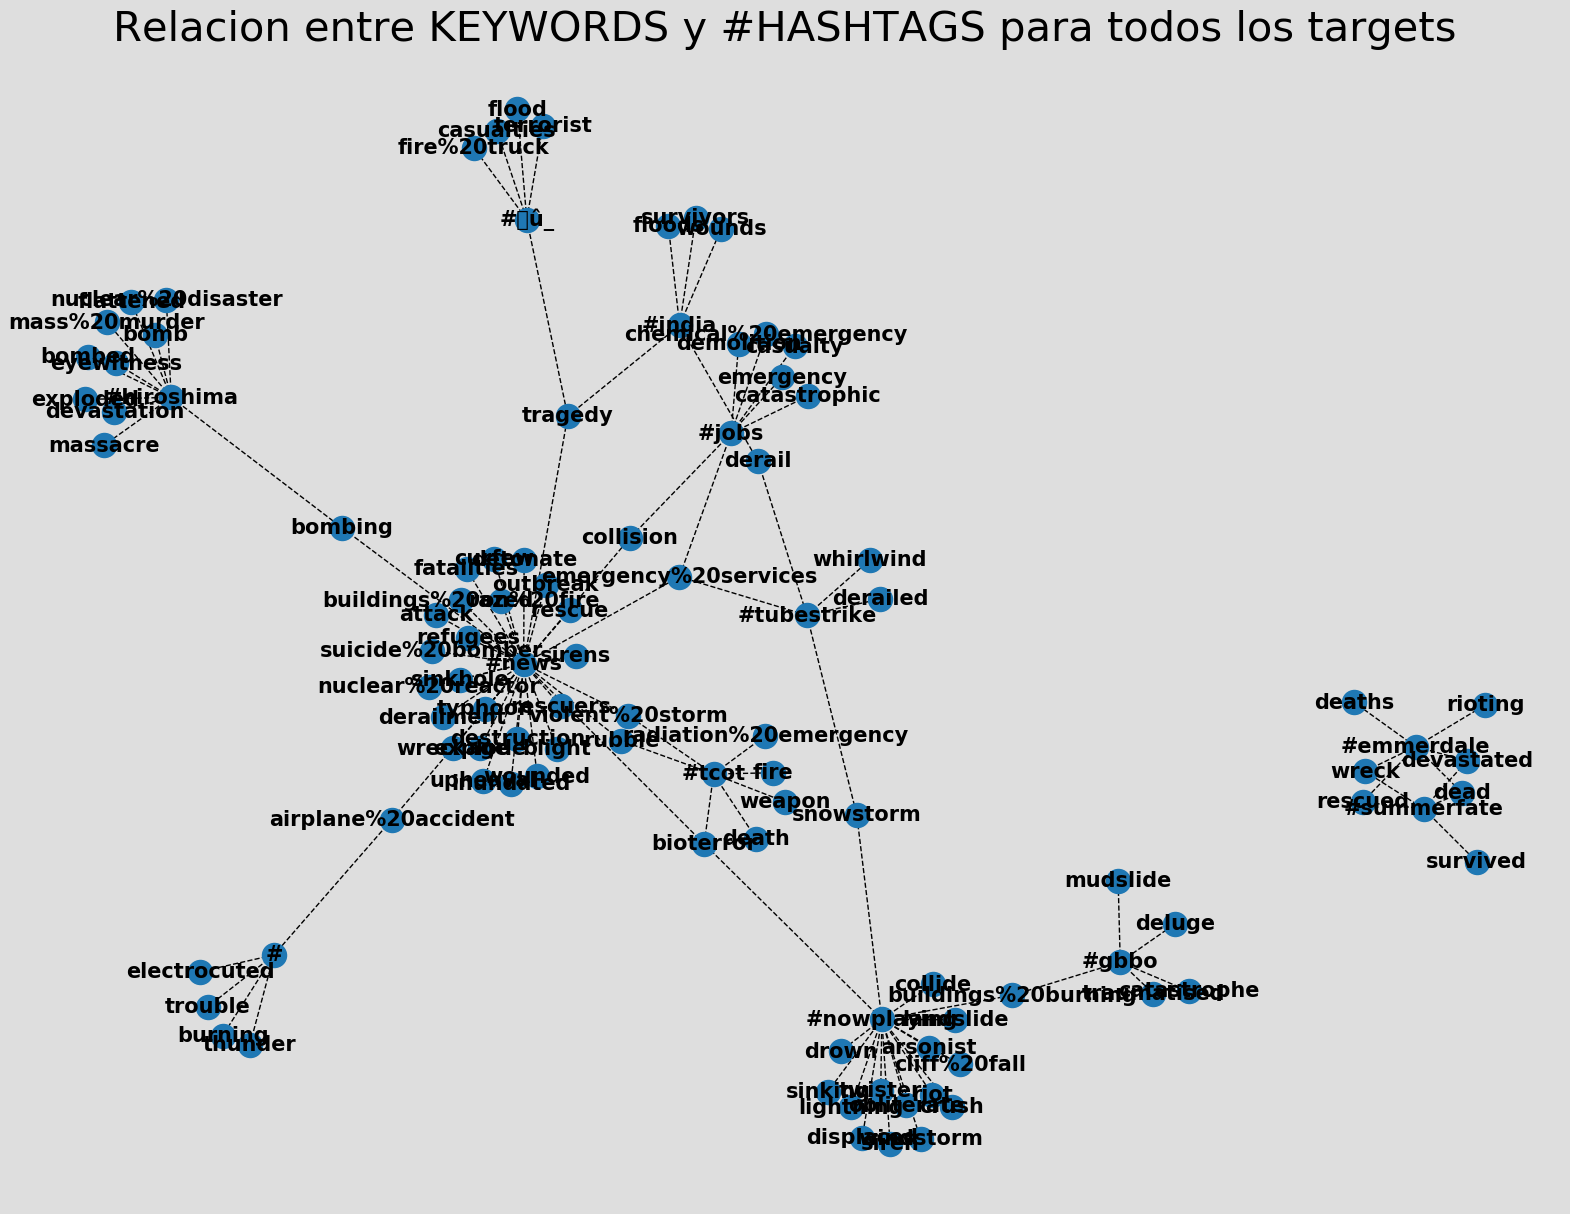

In [40]:
#palabras que hacen ref a tragedias
selected_words_singular=['fire','flood','inundate','earthquake','quake','deluge','euption','twister','tornado','hurricane', 'landslide','typhoon','wildfire','forest fire','drought','avalanche','urgent','important','danger','warrning','evacuation']
selected_words_plural=['fires','floods', 'earthquakes','quakes','deluges','rashes','tornadoes','hurricanes', 'landslides','typhoons','wildfires','forest fires','droughts','avalanches']
selected_words_other=['heat wave','died','flooding','flooded','damage','urgent','important','danger','warrning','help','evacuation']
col_one_list = nlp['keyword'].tolist()
selected_words = selected_words_singular + selected_words_plural + selected_words_other + col_one_list
s = set(selected_words)

nlp['words'] = nlp.text.str.strip().str.split()
palabras_tragedias = nlp.assign(matches=[len(set(el) & s) for el in nlp.words]).dropna()
#palabras_tragedias.head()

df_hashtags = palabras_tragedias[['text', 'target', 'keyword', 'matches']]
df_hashtags.dropna(inplace=True)
df_hashtags['words'] = palabras_tragedias.text.str.strip().str.split()
df_hashtags = df_hashtags.assign(hashtags=[filtrarPalabras(el) for el in df_hashtags.words])
df_hashtags = df_hashtags[['keyword', 'hashtags', 'matches', 'target']].dropna(how='any')
df_hashtags['hashtags'] = df_hashtags['hashtags'].str.lower()
#df_hashtags.head()

df_hashtags_keywords = pd.DataFrame(df_hashtags.hashtags.str.split(' ').tolist(), index=df_hashtags.keyword).stack()
df_hashtags_keywords = df_hashtags_keywords.reset_index([0, 'keyword'])
df_hashtags_keywords.columns = ['keyword', 'hashtags']
df_hashtags_keywords['hashtags'].replace('', np.nan, inplace=True)
df_hashtags_keywords = df_hashtags_keywords.dropna()
df_hashtags_keywords.drop_duplicates(inplace=True)

#hashtags con mas de 5 apariciones
hashtags_mas_usados = df_hashtags_keywords.groupby('hashtags')[['keyword']].count().reset_index().sort_values(by='keyword', ascending=False)
hashtags_mas_usados = hashtags_mas_usados[hashtags_mas_usados['keyword']>4]
#hashtags_mas_usados.head(30)

df_hashtags_keywords['popular'] = df_hashtags_keywords['hashtags'].isin(hashtags_mas_usados['hashtags'])
df_hashtags_keywords = df_hashtags_keywords[df_hashtags_keywords['popular']==True]
df_hashtags_keywords.head()

df_hashtags_keywords.shape

# Tamaño para hojas A4.
f, ax = plt.subplots(figsize=(20,15))

G=nx.from_pandas_edgelist(df_hashtags_keywords, 'hashtags', 'keyword')
nx.draw(G, with_labels=True, font_size=15, style='dashed', font_weight ='bold')

f.set_facecolor((0.85, 0.85, 0.85, 0.85))
ax.set_title("Relacion entre KEYWORDS y #HASHTAGS para todos los targets",fontsize=30)
plt.show()

#### 5.7 - ¿Qué relación hay entre los keywords y los hashtags en los tweets que hablan de desastres?

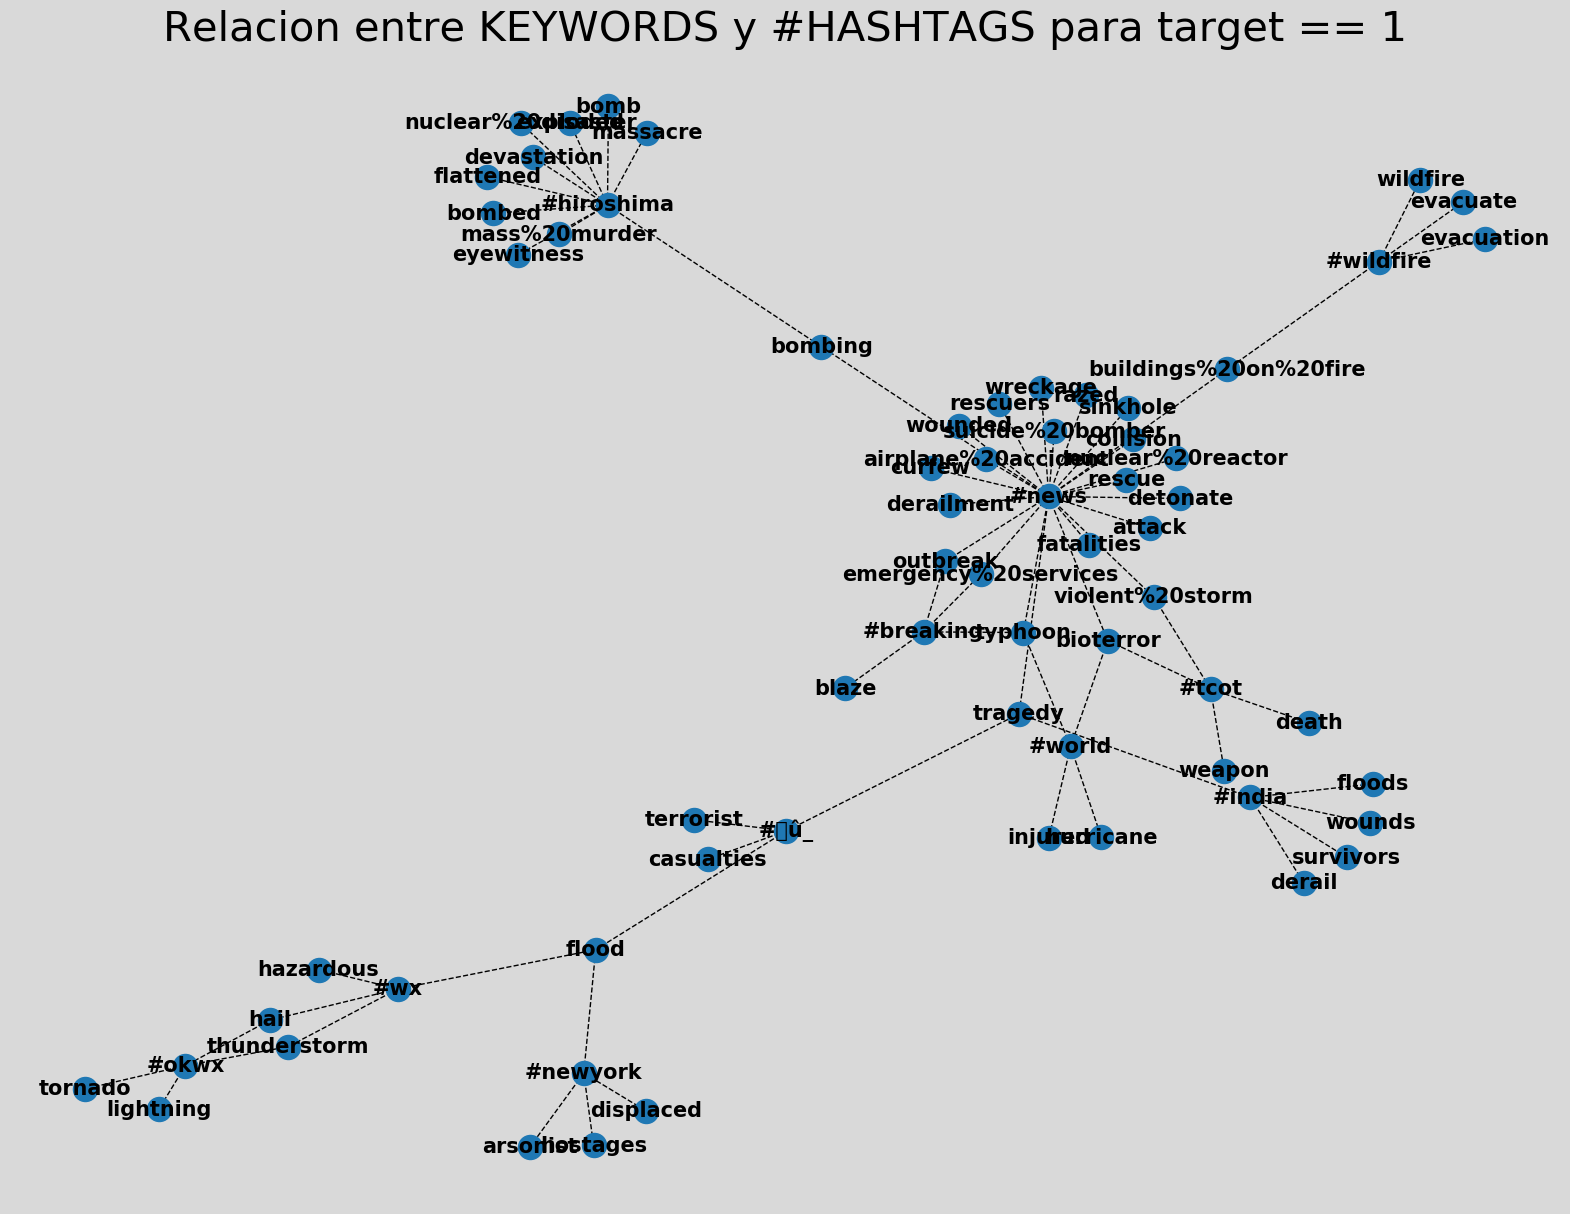

In [41]:
df_hashtag_target1 = df_hashtags[df_hashtags['target']==1]

#Separo los hashtags, 1 por fila y dropeo los que no tienen ninguno
df_hashtags_keywords_target1 = pd.DataFrame(df_hashtag_target1.hashtags.str.split(' ').tolist(), index=df_hashtag_target1.keyword).stack()
df_hashtags_keywords_target1 = df_hashtags_keywords_target1.reset_index([0, 'keyword'])
df_hashtags_keywords_target1.columns = ['keyword', 'hashtags']
df_hashtags_keywords_target1['hashtags'].replace('', np.nan, inplace=True)
df_hashtags_keywords_target1 = df_hashtags_keywords_target1.dropna()
df_hashtags_keywords_target1.drop_duplicates(inplace=True)


#hashtags con mas de 5 apariciones
hashtags_mas_usados = df_hashtags_keywords_target1.groupby('hashtags')[['keyword']].count().reset_index().sort_values(by='keyword', ascending=False)
hashtags_mas_usados = hashtags_mas_usados[hashtags_mas_usados['keyword']>3]
hashtags_mas_usados.head(50)

df_hashtags_keywords_target1['popular'] = df_hashtags_keywords_target1['hashtags'].isin(hashtags_mas_usados['hashtags'])
df_hashtags_keywords_target1 = df_hashtags_keywords_target1[df_hashtags_keywords_target1['popular']==True]

f, ax = plt.subplots(figsize=(20,15))

G=nx.from_pandas_edgelist(df_hashtags_keywords_target1, 'hashtags', 'keyword')
nx.draw(G, with_labels=True, font_size=15, style='dashed', font_weight ='bold')

f.set_facecolor((0.85, 0.85, 0.85))
ax.set_title("Relacion entre KEYWORDS y #HASHTAGS para target == 1",fontsize=30)
plt.show()

#### 5.8 - ¿Qué relación hay entre los keywords y los hashtags en los tweets que NO hablan de desastres?

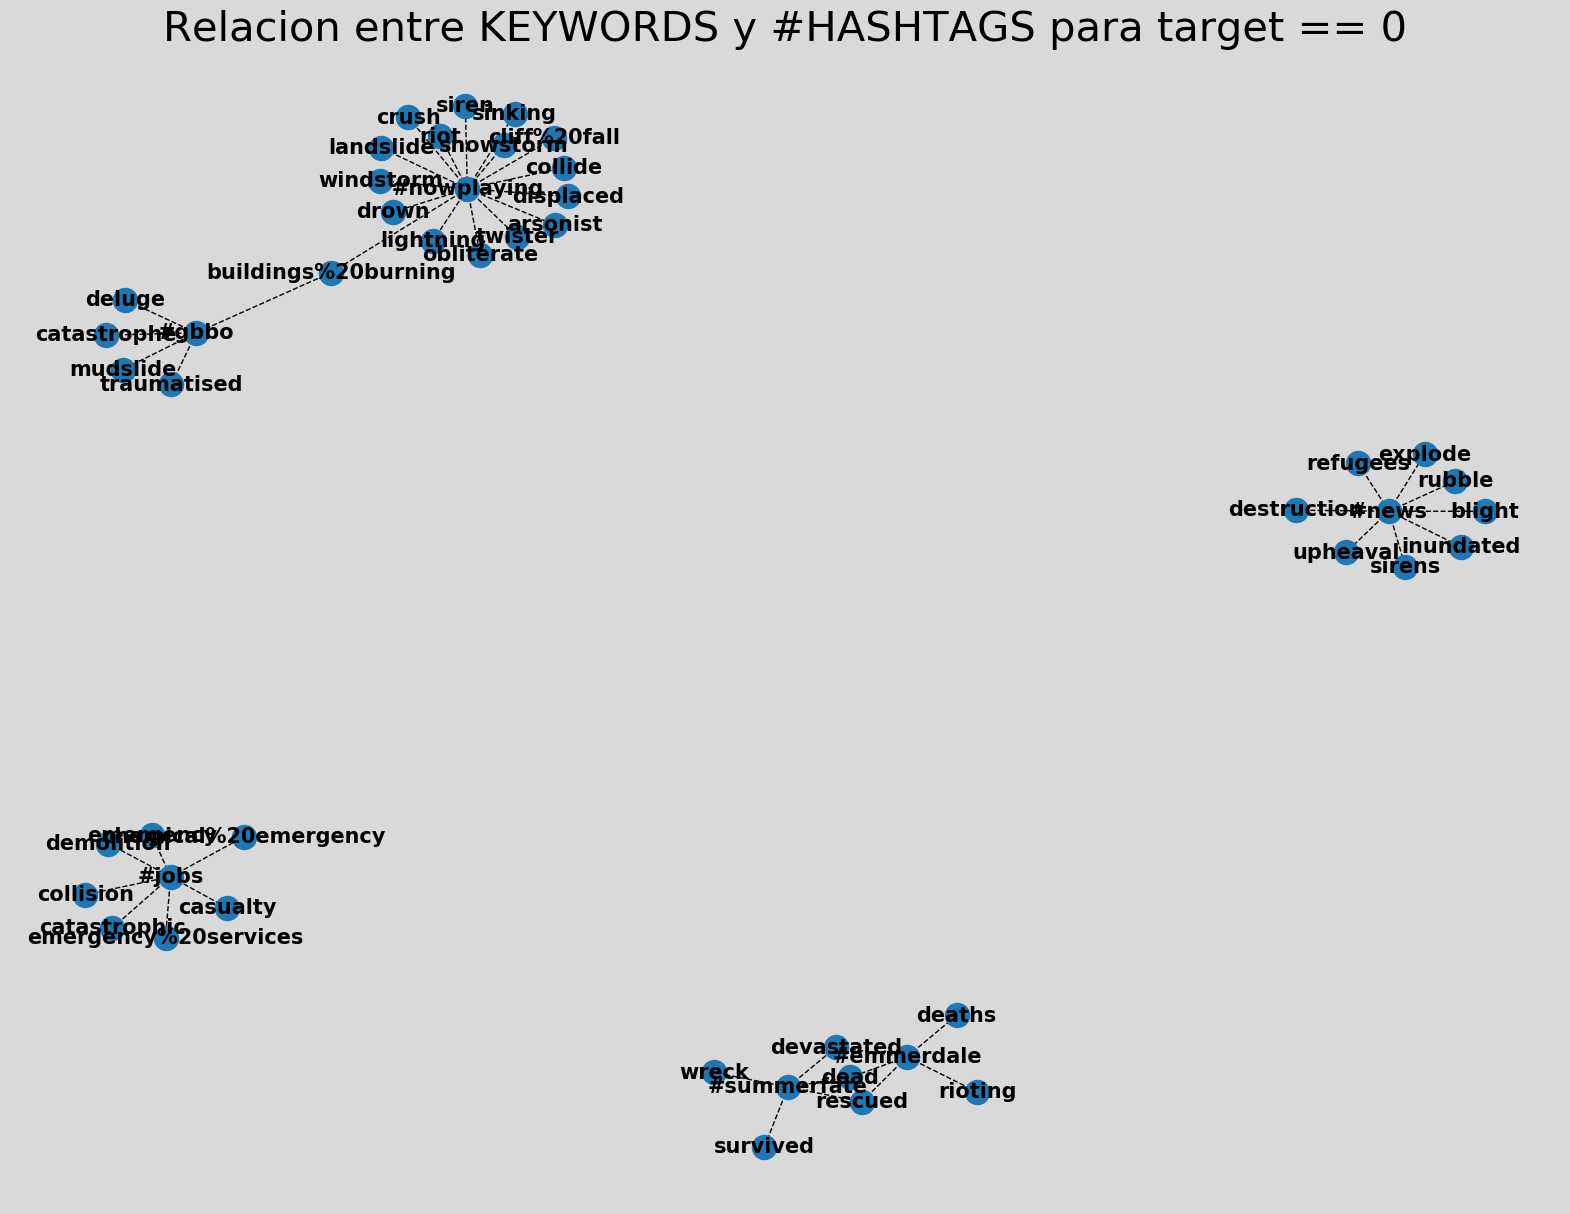

In [42]:
df_hashtag_target0 = df_hashtags[df_hashtags['target']==0]

#Separo los hashtags, 1 por fila y dropeo los que no tienen ninguno
df_hashtags_keywords_target0 = pd.DataFrame(df_hashtag_target0.hashtags.str.split(' ').tolist(), index=df_hashtag_target0.keyword).stack()
df_hashtags_keywords_target0 = df_hashtags_keywords_target0.reset_index([0, 'keyword'])
df_hashtags_keywords_target0.columns = ['keyword', 'hashtags']
df_hashtags_keywords_target0['hashtags'].replace('', np.nan, inplace=True)
df_hashtags_keywords_target0 = df_hashtags_keywords_target0.dropna()
df_hashtags_keywords_target0.drop_duplicates(inplace=True)

#hashtags con mas de 5 apariciones
hashtags_mas_usados = df_hashtags_keywords_target0.groupby('hashtags')[['keyword']].count().reset_index().sort_values(by='keyword', ascending=False)
hashtags_mas_usados = hashtags_mas_usados[hashtags_mas_usados['keyword']>4]
#hashtags_mas_usados.head()

df_hashtags_keywords_target0['popular'] = df_hashtags_keywords_target0['hashtags'].isin(hashtags_mas_usados['hashtags'])
df_hashtags_keywords_target0 = df_hashtags_keywords_target0[df_hashtags_keywords_target0['popular']==True]

# Tamaño para hojas A4.
f, ax = plt.subplots(figsize=(20,15))

G=nx.from_pandas_edgelist(df_hashtags_keywords_target0, 'hashtags', 'keyword')
nx.draw(G, with_labels=True, font_size=15, style='dashed', font_weight ='bold')

f.set_facecolor((0.85, 0.85, 0.85))
ax.set_title("Relacion entre KEYWORDS y #HASHTAGS para target == 0",fontsize=30)
plt.show()

### 6 - Análisis general sobre los hashtags utilizados en los tweet

#### 6.1 - ¿Cuál es la proporción de hashtags sobre el total de tweets?

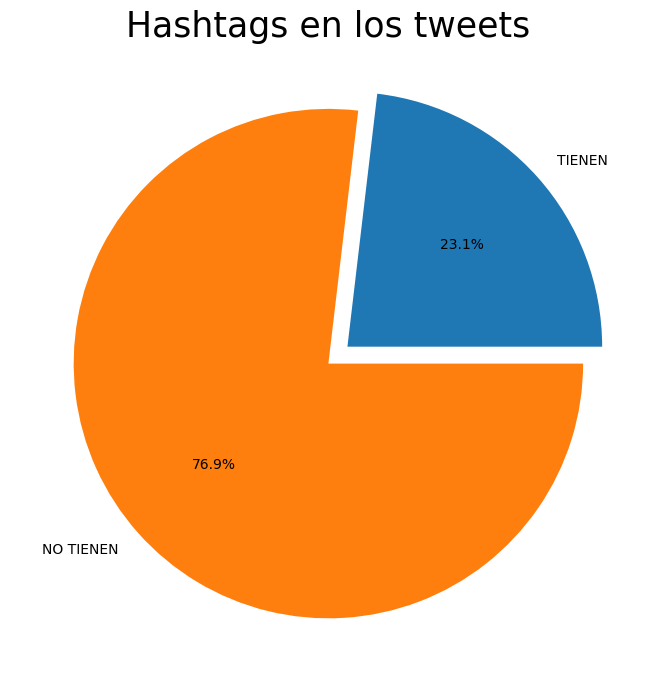

In [43]:
datos.groupby('target').count().reset_index()

datos['tieneHashtag'] = 'NO Tiene'
datos.loc[datos['hashtagsCantidad'] > 0, 'tieneHashtag'] = 'Tiene'

#Obtenemos las cantidades de propiedades con gimnasio
hashSI = (datos[datos['tieneHashtag'] == 'Tiene']).id.count()
hashNO = (datos[datos['tieneHashtag'] == 'NO Tiene']).id.count()

sizes = [hashSI, hashNO]
nombres = ['TIENEN','NO TIENEN']
# Tamaño para hojas A4.
plt.figure(figsize=(11.7, 8.27))
plt.title('Hashtags en los tweets', fontsize=25)
plt.pie(sizes, labels=nombres, autopct='%1.1f%%', shadow=False, explode=(0.1, 0))
plt.show()

#### 6.2 - ¿Cuáles son los hashtags más usados para tweets que representan desastres?

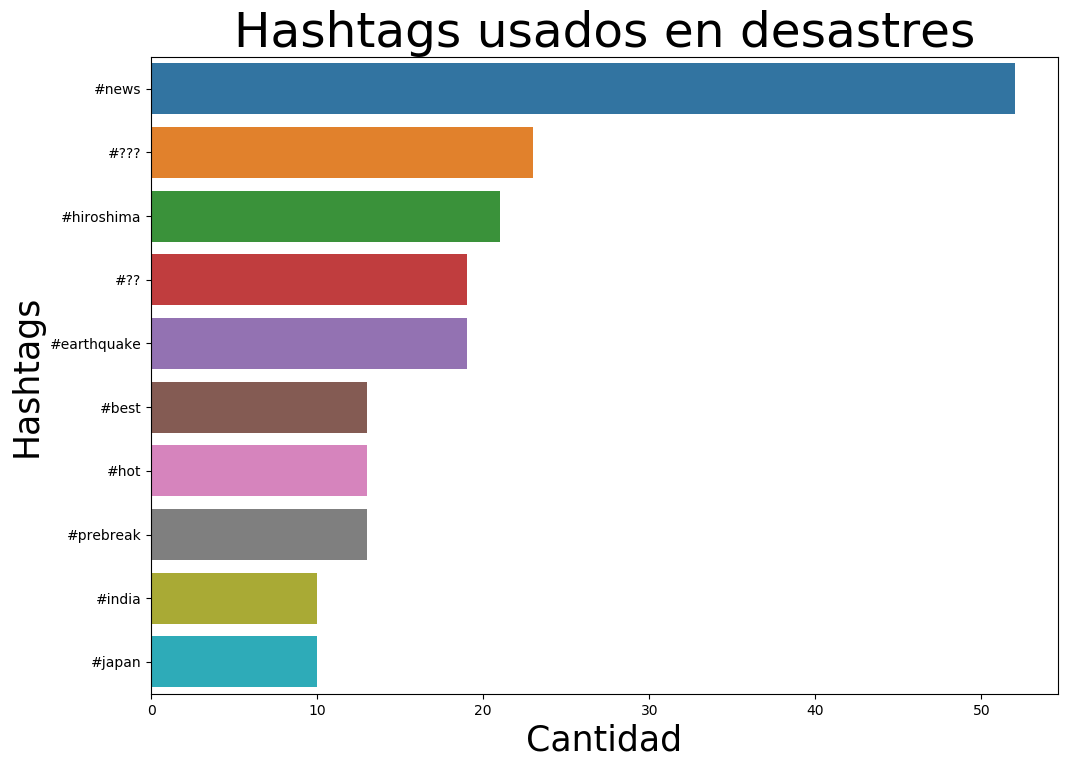

In [44]:
target1 = datos.loc[(datos['target'] == 1) & (datos['keyword'].notnull())]
target0 = datos.loc[(datos['target'] == 0) & (datos['keyword'].notnull())]
target1_WC = datos.loc[datos['target'] == 1]
target0_WC = datos.loc[datos['target'] == 0]

#split column Message to new df, create Serie by stack
s = (target1_WC.hashtags.str.split(expand=True).stack())
plt.figure(figsize=(11.7, 8.27))
#remove multiindex
s.index = s.index.droplevel(-1)
hashtag1_WC = s.to_frame('hash')
hashtag1_WC.reset_index(inplace=True)
hashtagss_count1 = hashtag1_WC.groupby('hash')['index'].count().reset_index(name='count')
barplot1 = hashtagss_count1.nlargest(10,'count')
ax = sns.barplot(data=barplot1, x='count',y='hash')
ax.axes.set_title("Hashtags usados en desastres",fontsize=35)
ax.set_xlabel("Cantidad",fontsize=25)
ax.set_ylabel("Hashtags",fontsize=25)
plt.show()

#### 6.3 - ¿Cómo se presentan los hashtags que están atribuidos a desastres?

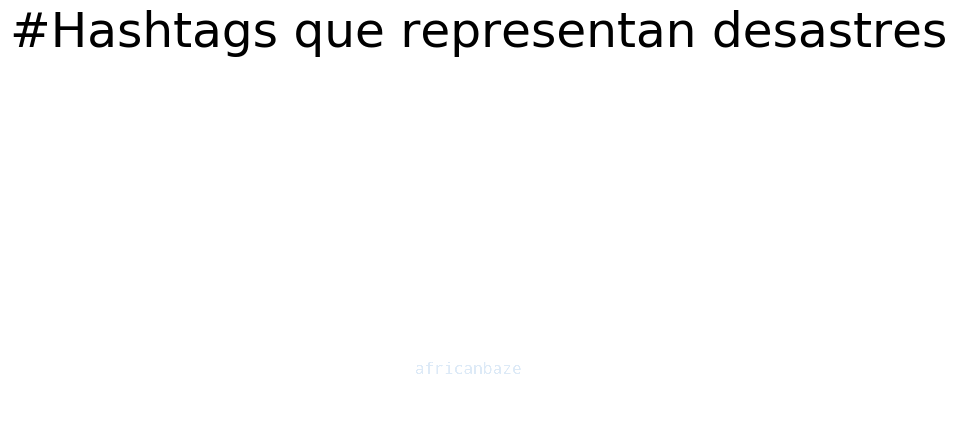

In [45]:
wave_mask = np.array(Image.open("twitter-logo.jpg"))
 
wordcloud = WordCloud(mask=wave_mask, colormap="Blues",max_font_size=50, max_words=250,background_color="white").generate(str(target1.hashtags.values).replace("'", "").replace(" ",""))
plt.title('#Hashtags que representan desastres',fontsize=35)
plt.margins(x=0, y=0)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### 6.4 - ¿Cuáles son los hashtags más usados para tweets que NO representan desastres?

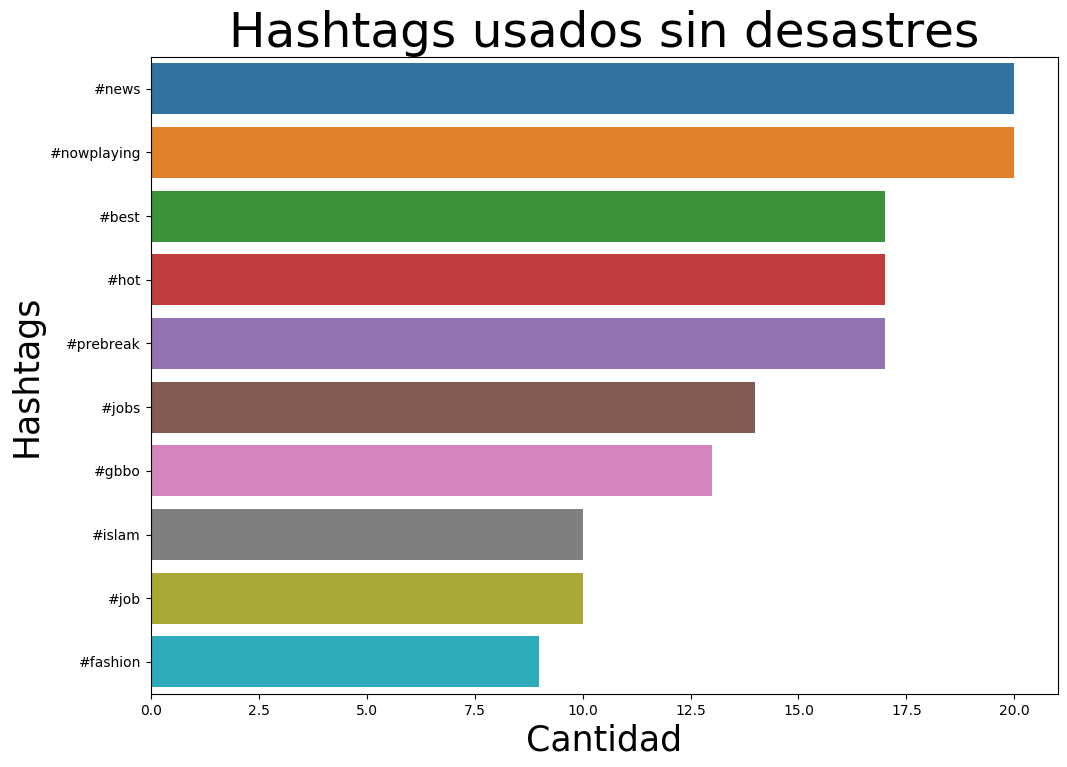

In [46]:
#split column Message to new df, create Serie by stack
s = (target0_WC.hashtags.str.split(expand=True).stack())
plt.figure(figsize=(11.7, 8.27))
#remove multiindex
s.index = s.index.droplevel(-1)
hashtag0_WC = s.to_frame('hash')
hashtag0_WC.reset_index(inplace=True)
hashtagss_count0 = hashtag0_WC.groupby('hash')['index'].count().reset_index(name='count')
barplot0 = hashtagss_count0.nlargest(10,'count')
ax = sns.barplot(data=barplot0, x='count',y='hash')
ax.axes.set_title("Hashtags usados sin desastres",fontsize=35)
ax.set_xlabel("Cantidad",fontsize=25)
ax.set_ylabel("Hashtags",fontsize=25)
plt.show()

#### 6.5 - ¿Cómo se presentan los hashtags que NO están atribuidos a desastres?

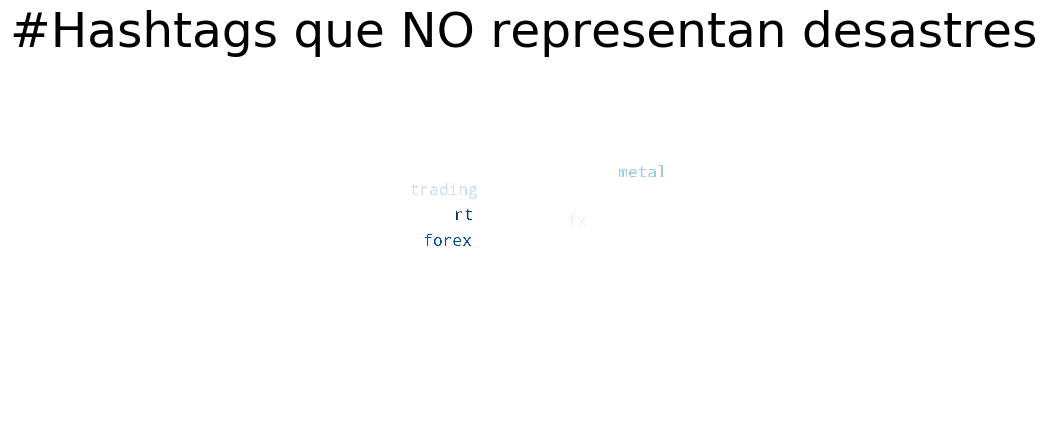

In [47]:
wave_mask = np.array(Image.open("twitter-logo.jpg"))
 
wordcloud = WordCloud(mask=wave_mask, colormap="Blues",max_font_size=50, max_words=100,background_color="white").generate(str(target0.hashtags.values).replace("'", "").replace(" ",""))
plt.title('#Hashtags que NO representan desastres',fontsize=35)
plt.margins(x=0, y=0)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()